# Predictions for the NEOCP using current criteria

In this notebook we show our predictions for the near-Earth object confirmation page in the Era of LSST when using current submission criteria.

You can find the code creating Figures 1, 3 & 4.

In [124]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import pandas as pd

import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u

from datetime import date

import numpy as np
from os import listdir

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import helpers

import difi

In [3]:
import sys
sys.path.append("../mitigation_algorithm/")
import magnitudes

In [4]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [5]:
from importlib import reload

# Set up S3M ID conversion

In [6]:
s3m = pd.read_hdf("../../hybrid-sso-catalogs/catalogues/s3m_initial.h5")
hex_ids = np.array(['{:07X}'.format(num) for num in np.arange(len(s3m.index.values))])
s3m_to_hex7 = dict(zip(s3m.index.values, hex_ids))

# Get `digest2` scores

### Attach extra info to files

In [350]:
def attach_nobs_scores_to_files(file_ids=range(24), path="mba/"):
    # go through each visit file
    for file in file_ids:
        print(f"Starting file {file}")
        # read in the file and set hex_id as the index
        visit_file = pd.read_hdf(path + f"filtered_visit_{file:03d}.h5")
        visit_file.set_index("hex_id", inplace=True)

        # get a list of nights in the file
        nights = np.sort(visit_file["night"].unique())
        nightly_visits = [None for _ in range(len(nights))]

        # loop over the nights
        for i, night in enumerate(nights):
            if night > 372:
                break
            # get the specific rows for this night
            nightly_visit_file = visit_file[visit_file["night"] == night]

            # calculate n_obs for each row and save as a new column
            n_obs = nightly_visit_file.groupby("ObjID").size().to_frame("n_obs")
            nightly_visit_file = nightly_visit_file.join(n_obs, on="ObjID")

            # read in the scores, remove duplicates
            scores, hex_ids = helpers.get_neo_scores(path, night=night)
            
            uni, inds = np.unique(hex_ids, return_index=True)

            # add scores as a new column
            scores_df = pd.DataFrame(dict(scores=scores[inds], hex_id=hex_ids[inds])).set_index("hex_id")
            nightly_visits[i] = nightly_visit_file.join(scores_df, on="hex_id")

            print(f"  Done with night {night}")

        # recombine the dataframes and save as a new file
        visit_file = pd.concat(nightly_visits)
        visit_file.to_hdf(path + f"filtered_visit_scores_{file:03d}.h5", key="df")

        print(f"  Done saving")

In [351]:
%%time
attach_nobs_scores_to_files(path="neo/")

Starting file 22
  Done with night 374
  Done with night 375
  Done with night 376
  Done with night 379
  Done with night 380
  Done with night 381
  Done with night 383
  Done with night 384
  Done with night 385
  Done with night 386
  Done with night 387
  Done with night 388
  Done with night 389
  Done with night 390
  Done with night 391
  Done with night 392
  Done saving
Starting file 23
  Done with night 392
  Done with night 393
  Done with night 394
  Done with night 395
  Done with night 396
  Done with night 398
  Done with night 407
  Done with night 408
  Done with night 409
  Done with night 410
  Done with night 411
  Done with night 412
  Done with night 414
  Done with night 415
  Done with night 416
  Done with night 417
  Done saving
CPU times: user 504 ms, sys: 41.8 ms, total: 546 ms
Wall time: 1.17 s


In [352]:
%%time
attach_nobs_scores_to_files(path="mba/")

Starting file 22
  Done with night 374
  Done with night 375
  Done with night 376
  Done with night 379
  Done with night 380
  Done with night 381
  Done with night 383
  Done with night 384
  Done with night 385
  Done with night 386
  Done with night 387
  Done with night 388
  Done with night 389
  Done with night 390
  Done with night 391
  Done with night 392
  Done saving
Starting file 23
  Done with night 392
  Done with night 393
  Done with night 394
  Done with night 395
  Done with night 396
  Done with night 398
  Done with night 407
  Done with night 408
  Done with night 409
  Done with night 410
  Done with night 411
  Done with night 412
  Done with night 414
  Done with night 415
  Done with night 416
  Done with night 417
  Done saving
CPU times: user 15.8 s, sys: 1.48 s, total: 17.3 s
Wall time: 19.9 s


### Get scores for different n_obs

In [7]:
neo_streakers = pd.read_hdf("../mitigation_algorithm/neo_streakers.h5")
streaker_ids = neo_streakers["ObjID"].values

In [9]:
visit_file = pd.read_hdf(f"neo/filtered_visit_scores_{0:03d}.h5")

In [16]:
df = visit_file[visit_file["night"] == 0]
df.loc["000003E"]

,ObjID,night,FieldMJD,AstRA(deg),AstDec(deg),filter,MaginFilter,AstrometricSigma(mas),PhotometricSigma(mag),n_obs,scores
hex_id,,,,,,,,,,,
000003E,S0000012a,0,60218.389758,131.311551,0.456672,r,15.885709,10.300264,0.002477,2,100.0
000003E,S0000012a,0,60218.392846,131.309094,0.457416,r,15.891093,10.296002,0.002561,2,100.0


In [29]:
visit_file[visit_file["night"] == 0].groupby("hex_id").first().index

Index(['000003E', '0000091', '0000093', '000009D', '000012C', '0000167',
       '000017D', '0000221', '000022F', '0000311', '000034C', '00003A9',
       '0000437', '00005B4', '0000718', '000093C', '00009D1', '00009DF',
       '0000A19', '0000DC6', '0000F23', '0000F9F', '00010A6', '000119D',
       '0001571', '000181D', '0001A44', '00022BA', '0002439', '0002776',
       '0002F45', '0002FCC', '000333F', '0003D13', '0004154', '00043CC',
       '0004DF8', '000514A', '00059C1', '0005BB2', '0006A86', '0008F4C',
       '00091A6', '000CE18', '000F2A0', '000F8BF', '0016D8E', '001D5B6',
       '00309F5', '003FD07'],
      dtype='object', name='hex_id')

In [47]:
magnitudes.convert_colour_mags(mag=df.loc["000003E"]["MaginFilter"].values,
                               in_colour=df.loc["000003E"]["filter"].values,
                               out_colour="V")

array([16.06570893, 16.07109307])

In [165]:
visit_file["test"] = 1 / visit_file["n_obs"]
x = visit_file.groupby(["ObjID"]).sum()["test"]

In [167]:
x.mean()

2.5587044534412957

In [183]:
bad_ids = np.load("delete_s3m_ids.npy", allow_pickle=True)

False

In [191]:
hybrid = pd.read_hdf("../../hybrid-sso-catalogs/catalogues/hybrid.h5")

In [195]:
hybrid_mine = pd.read_hdf("../../hybrid-sso-catalogs/catalogues/hybrid_cart.h5_")

In [197]:
hybrid

,id,x,y,z,vx,vy,vz,t_0,H,g
S0000001a,0.0,1.002707,-2.270354,0.270853,0.006986,0.006449,0.000764,60065.0,10.315,0.15
S0000002a,1.0,-1.340302,0.049768,0.315832,0.004456,-0.017984,0.002931,60065.0,10.818,0.15
S0000003a,2.0,0.428412,2.723093,0.117611,-0.006465,-0.001281,0.000996,60065.0,11.175,0.15
S0000004a,3.0,-3.323234,1.285990,0.714961,-0.006735,-0.001570,0.002044,60065.0,11.452,0.15
S0000005a,4.0,-2.676187,0.422739,-0.679356,-0.007573,-0.004757,-0.003668,60065.0,11.678,0.15
...,...,...,...,...,...,...,...,...,...,...
2021 DL2,1281400.0,1.074597,0.994689,-0.213967,-0.012452,0.009575,0.001386,60065.0,20.300,0.15
2021 EH5,1281401.0,-0.514883,1.365796,0.526131,-0.014470,-0.003516,-0.000686,60065.0,20.100,0.15
2021 FT2,1281402.0,-1.265895,1.422500,-0.451276,-0.009300,-0.006191,0.003801,60065.0,20.100,0.15
2021 FB3,1281403.0,2.597167,0.028690,-0.698164,-0.003838,0.005610,-0.006204,60065.0,20.300,0.15


In [193]:
s3m_to_hex7["S0000003a"]

'0000002'

In [190]:
bad_ids

array(['S0000003a', 'S000000Fa', 'S000000Ga', ..., 'St500zTVa',
       'St500zo1a', 'St500zwTa'], dtype=object)

In [189]:
table = None

for file in range(22):
    print(f"file {file}")
    visit_file = pd.read_hdf(f"neo/filtered_visit_scores_{file:03d}.h5")
    
    if visit_file["ObjID"].isin(bad_ids).any():
        print("Definitely panic")
    
    for x in visit_file["ObjID"]:
        if x[0] != "S":
            print("Panic")

file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19
file 20
file 21


(array([  0., 433., 303., 197., 126.,  84.,  56.,  22.,  11.,   2.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <BarContainer object of 10 artists>)

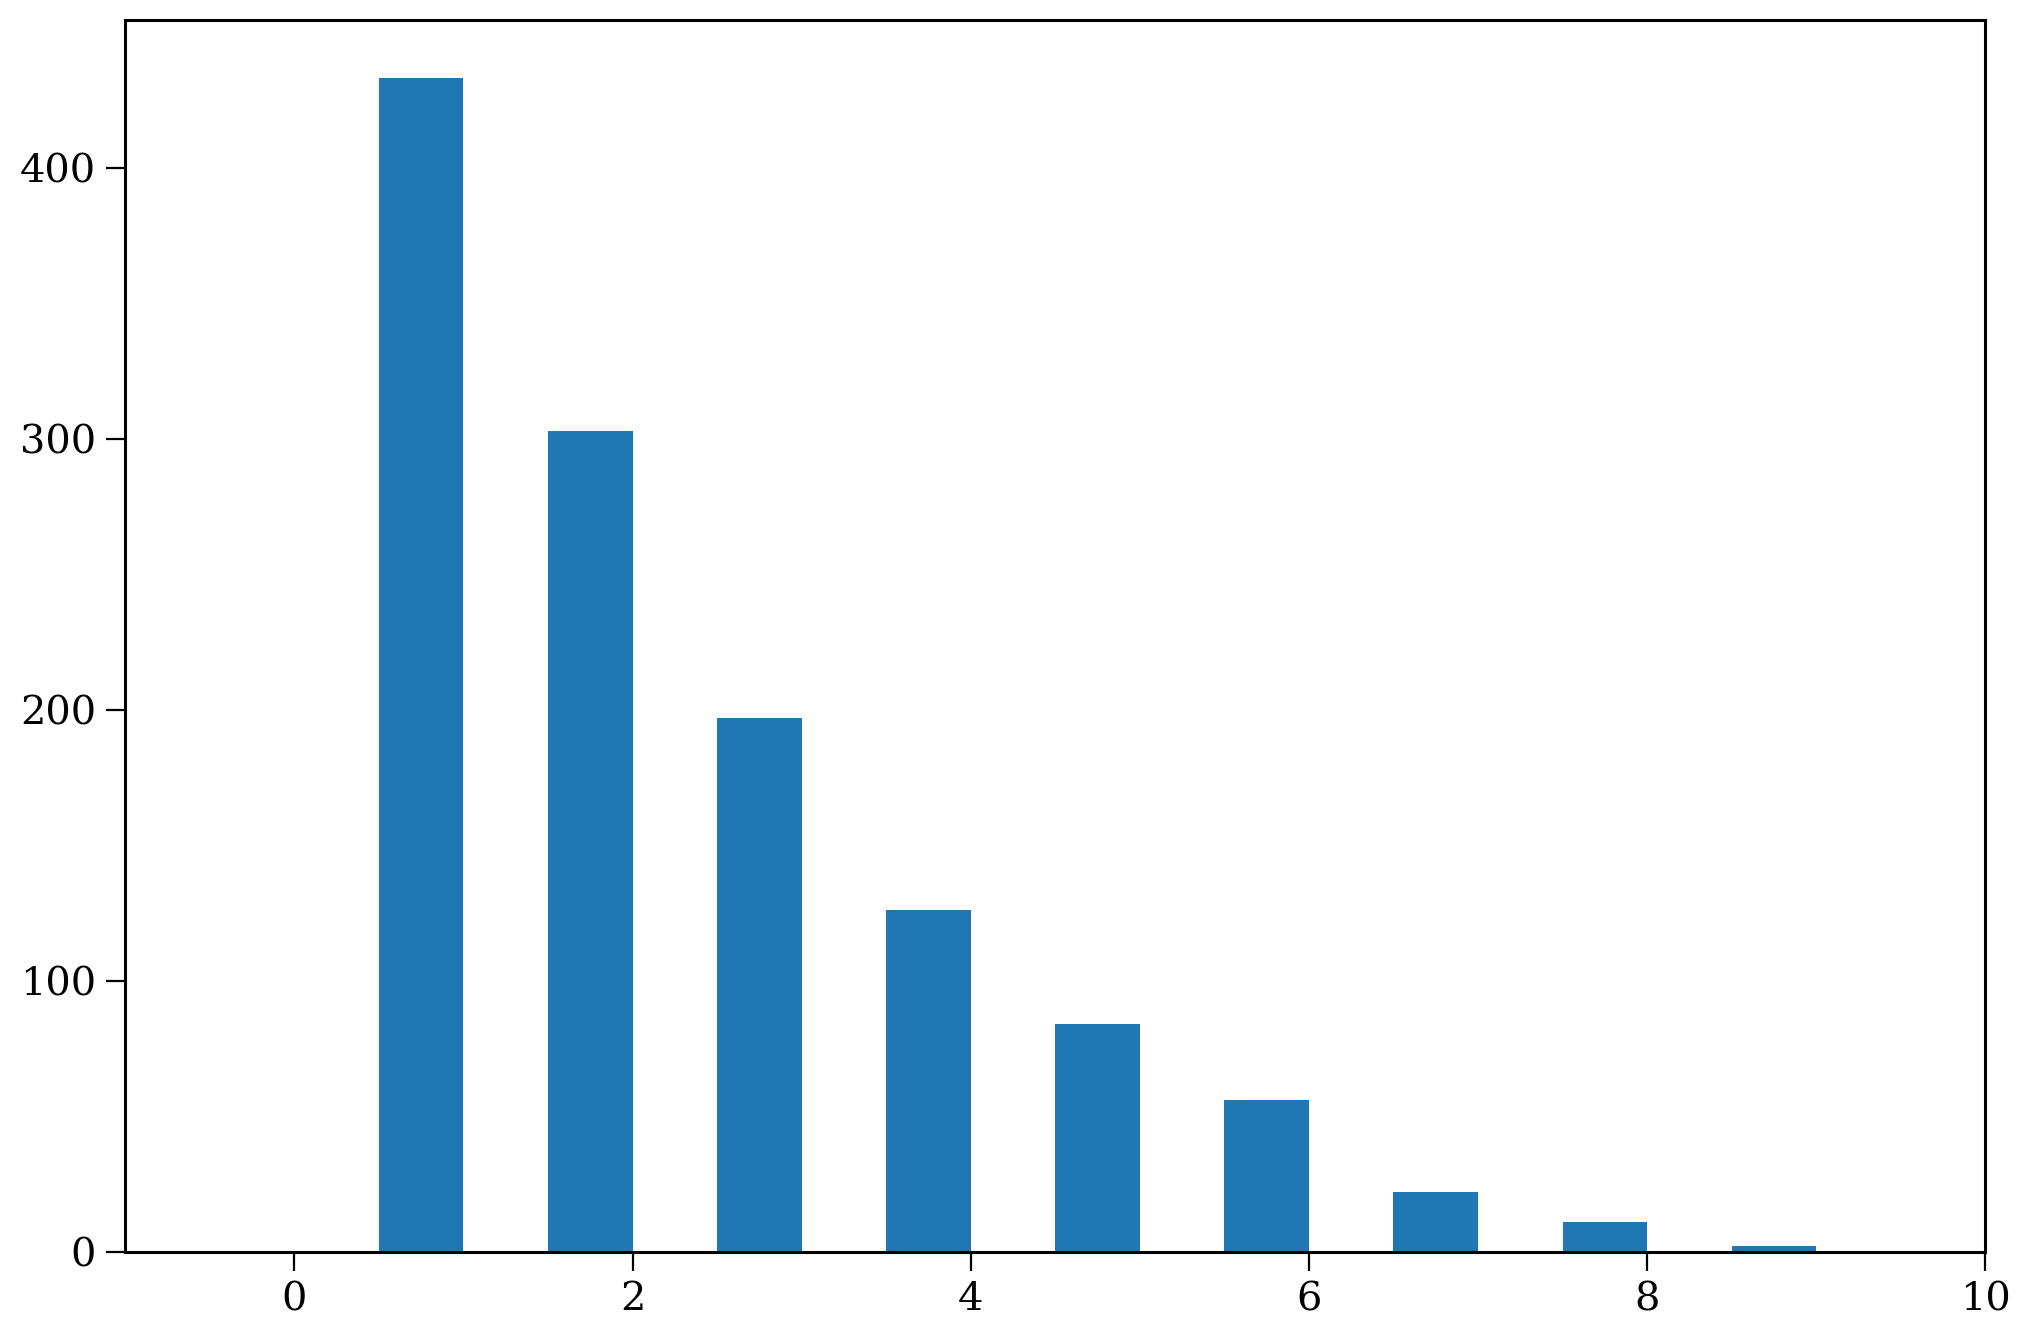

In [173]:
plt.hist(x, bins=np.arange(11) - 0.5, width=0.5)

In [147]:
def get_counts(path="neo/", n_obs_list=[2, 2, 3, 3, 4, 5, 6], last_night=373, remove_streaks=True):
    counts = np.zeros((last_night, len(n_obs_list))).astype(int)
    streak_counts = np.zeros(last_night).astype(int)
    n_too_faint = 0
    
    all_mags = []
    fast_mags = []
    
    problems = 0
    alt_problems = 0
    
    for file in range(22):
        print(f"file {file}")
        visit_file = pd.read_hdf(path + f"filtered_visit_scores_{file:03d}.h5")
        visit_file["v_mag"] = magnitudes.convert_colour_mags(visit_file["MaginFilter"].values, out_colour="V",
                                                             in_colour=visit_file["filter"].values)
        nights = visit_file["night"].unique()
        for night in nights:
            if night >= last_night:
                break
            nightly_visit = visit_file[visit_file["night"] == night]
            grouped = nightly_visit.groupby("hex_id").first()
            
            grouped["max_v_mag"] = nightly_visit.groupby("hex_id")["v_mag"].max()
            

            if path == "neo/" and remove_streaks:
                no_streaks = ~(np.isin(grouped["ObjID"], neo_streakers["ObjID"][neo_streakers["night"] == night]))
                fast_mags = np.concatenate((fast_mags, grouped["v_mag"][~no_streaks]))
                grouped = grouped[no_streaks]
                streak_counts[night] = (~no_streaks).sum()
            
            max_mag = 21
            
            proper_mag_mask = grouped["max_v_mag"].values <= max_mag
            
#             print((grouped["v_mag"] <= 22).sum() - proper_mag_mask.sum())
#             print(proper_mag_mask)
#             print(grouped["v_mag"].values <= 22, '\n')
            
            assert proper_mag_mask.sum() <= (grouped["v_mag"] <= max_mag).sum()
            problems += (grouped["v_mag"] <= max_mag).sum() - proper_mag_mask.sum()
            
            for i, n_obs in enumerate(n_obs_list):
                no_mag_mask = (grouped["n_obs"] >= n_obs) & (grouped["scores"] >= 65)
                full_mask = no_mag_mask & proper_mag_mask
                
                if i == 0:
                    n_too_faint += (no_mag_mask.sum() - full_mask.sum())
                    counts[night, i] += no_mag_mask.sum()
                    all_mags = np.concatenate((all_mags, grouped["v_mag"]))
                    alt_problems += (no_mag_mask & (grouped["v_mag"] <= max_mag)).sum() - full_mask.sum()
                else:
                    counts[night, i] += full_mask.sum()

    print("PROBLEMS", problems)
    print("REAL PROBLEMS", alt_problems)
    print(n_too_faint)
    
    if path == "neo/":
        return counts, streak_counts, all_mags, fast_mags
    else:           
        return counts

In [148]:
%%time
neo_counts, streak_counts, all_mags, fast_mags = get_counts()

file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19
file 20
file 21
PROBLEMS 302
REAL PROBLEMS 249
37767
CPU times: user 3.38 s, sys: 184 ms, total: 3.56 s
Wall time: 3.52 s


In [169]:
neo_counts[:, 0:2].sum(axis=0)

array([45515,  7748])

In [136]:
"With 21st", neo_counts[:, 1].sum()

('With 21st', 2284)

In [139]:
"With 22nd", neo_counts[:, 1].sum()

('With 22nd', 4864)

In [130]:
neo_counts[:, 0].sum() - neo_counts[:, 1].sum()

12086

In [134]:
(neo_counts[:, 0].sum() - neo_counts[:, 1].sum()) / neo_counts[:, 0].sum()

0.8143994799284902

In [143]:
%%time
mba_counts = get_counts(path="mba/")

file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19
file 20
file 21
PROBLEMS 51053
REAL PROBLEMS 3616
217998
CPU times: user 2min 58s, sys: 31.2 s, total: 3min 29s
Wall time: 3min 27s


In [119]:
(mba_counts[:, 0].sum() - mba_counts[:, 1].sum()) / mba_counts[:, 0].sum()

0.31659647160595233

In [144]:
"With 21st", mba_counts[:, 1].sum()

('With 21st', 239774)

In [141]:
"With 22nd", mba_counts[:, 1].sum()

('With 22nd', 312843)

## NEOCP Traffic and Purity using current criteria

In [69]:
nights = np.arange(373)
n_obs_list = [3, 4, 5, 6]

In [70]:
total_traffic = neo_counts + mba_counts

In [71]:
bad_weather = nights[total_traffic[:, 0] == 0]

In [72]:
purity = neo_counts / total_traffic

/tmp/ipykernel_35849/4177174142.py:1: RuntimeWarning: invalid value encountered in true_divide
  purity = neo_counts / total_traffic


In [101]:
streak_counts.sum()

6655

In [120]:
c = Counter(neo_streakers["ObjID"])

In [73]:
def weekly_mean(x, bad_weather, size=3):
    y = np.repeat(np.nan, len(x))
    for i in range(len(x)):
        if i not in bad_weather:
            inds = np.arange(max(0, i - size), min(i + size + 1, len(x)))
            inds = inds[~np.isin(inds, bad_weather)]
            y[i] = np.nanmean(x[inds])
    return y

In [211]:
total_traffic

array([[ 485,  457,  323,   36,   15],
       [1222, 1216, 1059,  154,  137],
       [ 404,  375,  333,   12,   12],
       ...,
       [ 851,  686,  564,   34,   27],
       [ 118,   42,   30,    0,    0],
       [ 814,  720,  503,   30,    4]])

In [214]:
total_traffic[273]

array([21257,  6494,  3917,  1998,  1380])

In [213]:
np.where(total_traffic == np.max(total_traffic))

(array([273]), array([0]))

In [221]:
weekly_mean(total_traffic.T[0 + 1], bad_weather, size=smoothing_window)
weekly_mean(total_traffic.T[0 + 1], bad_weather, size=3)

array([ 685.5       ,  771.8       ,  847.83333333,  923.        ,
        905.57142857,  891.28571429,  981.        , 1009.        ,
        996.71428571,  965.42857143,  867.71428571,  869.71428571,
        776.57142857,  820.85714286,  820.        ,  729.42857143,
        682.83333333,  775.83333333,  768.16666667,           nan,
        646.66666667,  591.66666667,  587.        ,  588.42857143,
        478.5       ,  568.33333333,  541.83333333,           nan,
        545.        ,  675.5       ,  737.5       ,  737.5       ,
        716.6       ,  768.25      ,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,  490.        ,  621.6       ,  673.16666667,
        617.14285714,  664.28571429,  716.14285714,  808.14285714,
        791.42857143,  773.        ,  676.42857143,  728.71428571,
        902.28571429,  881.14285714,  852.85714286,  756.85714286,
        625.        ,  858.28571429,  916.14285714,  801.28571

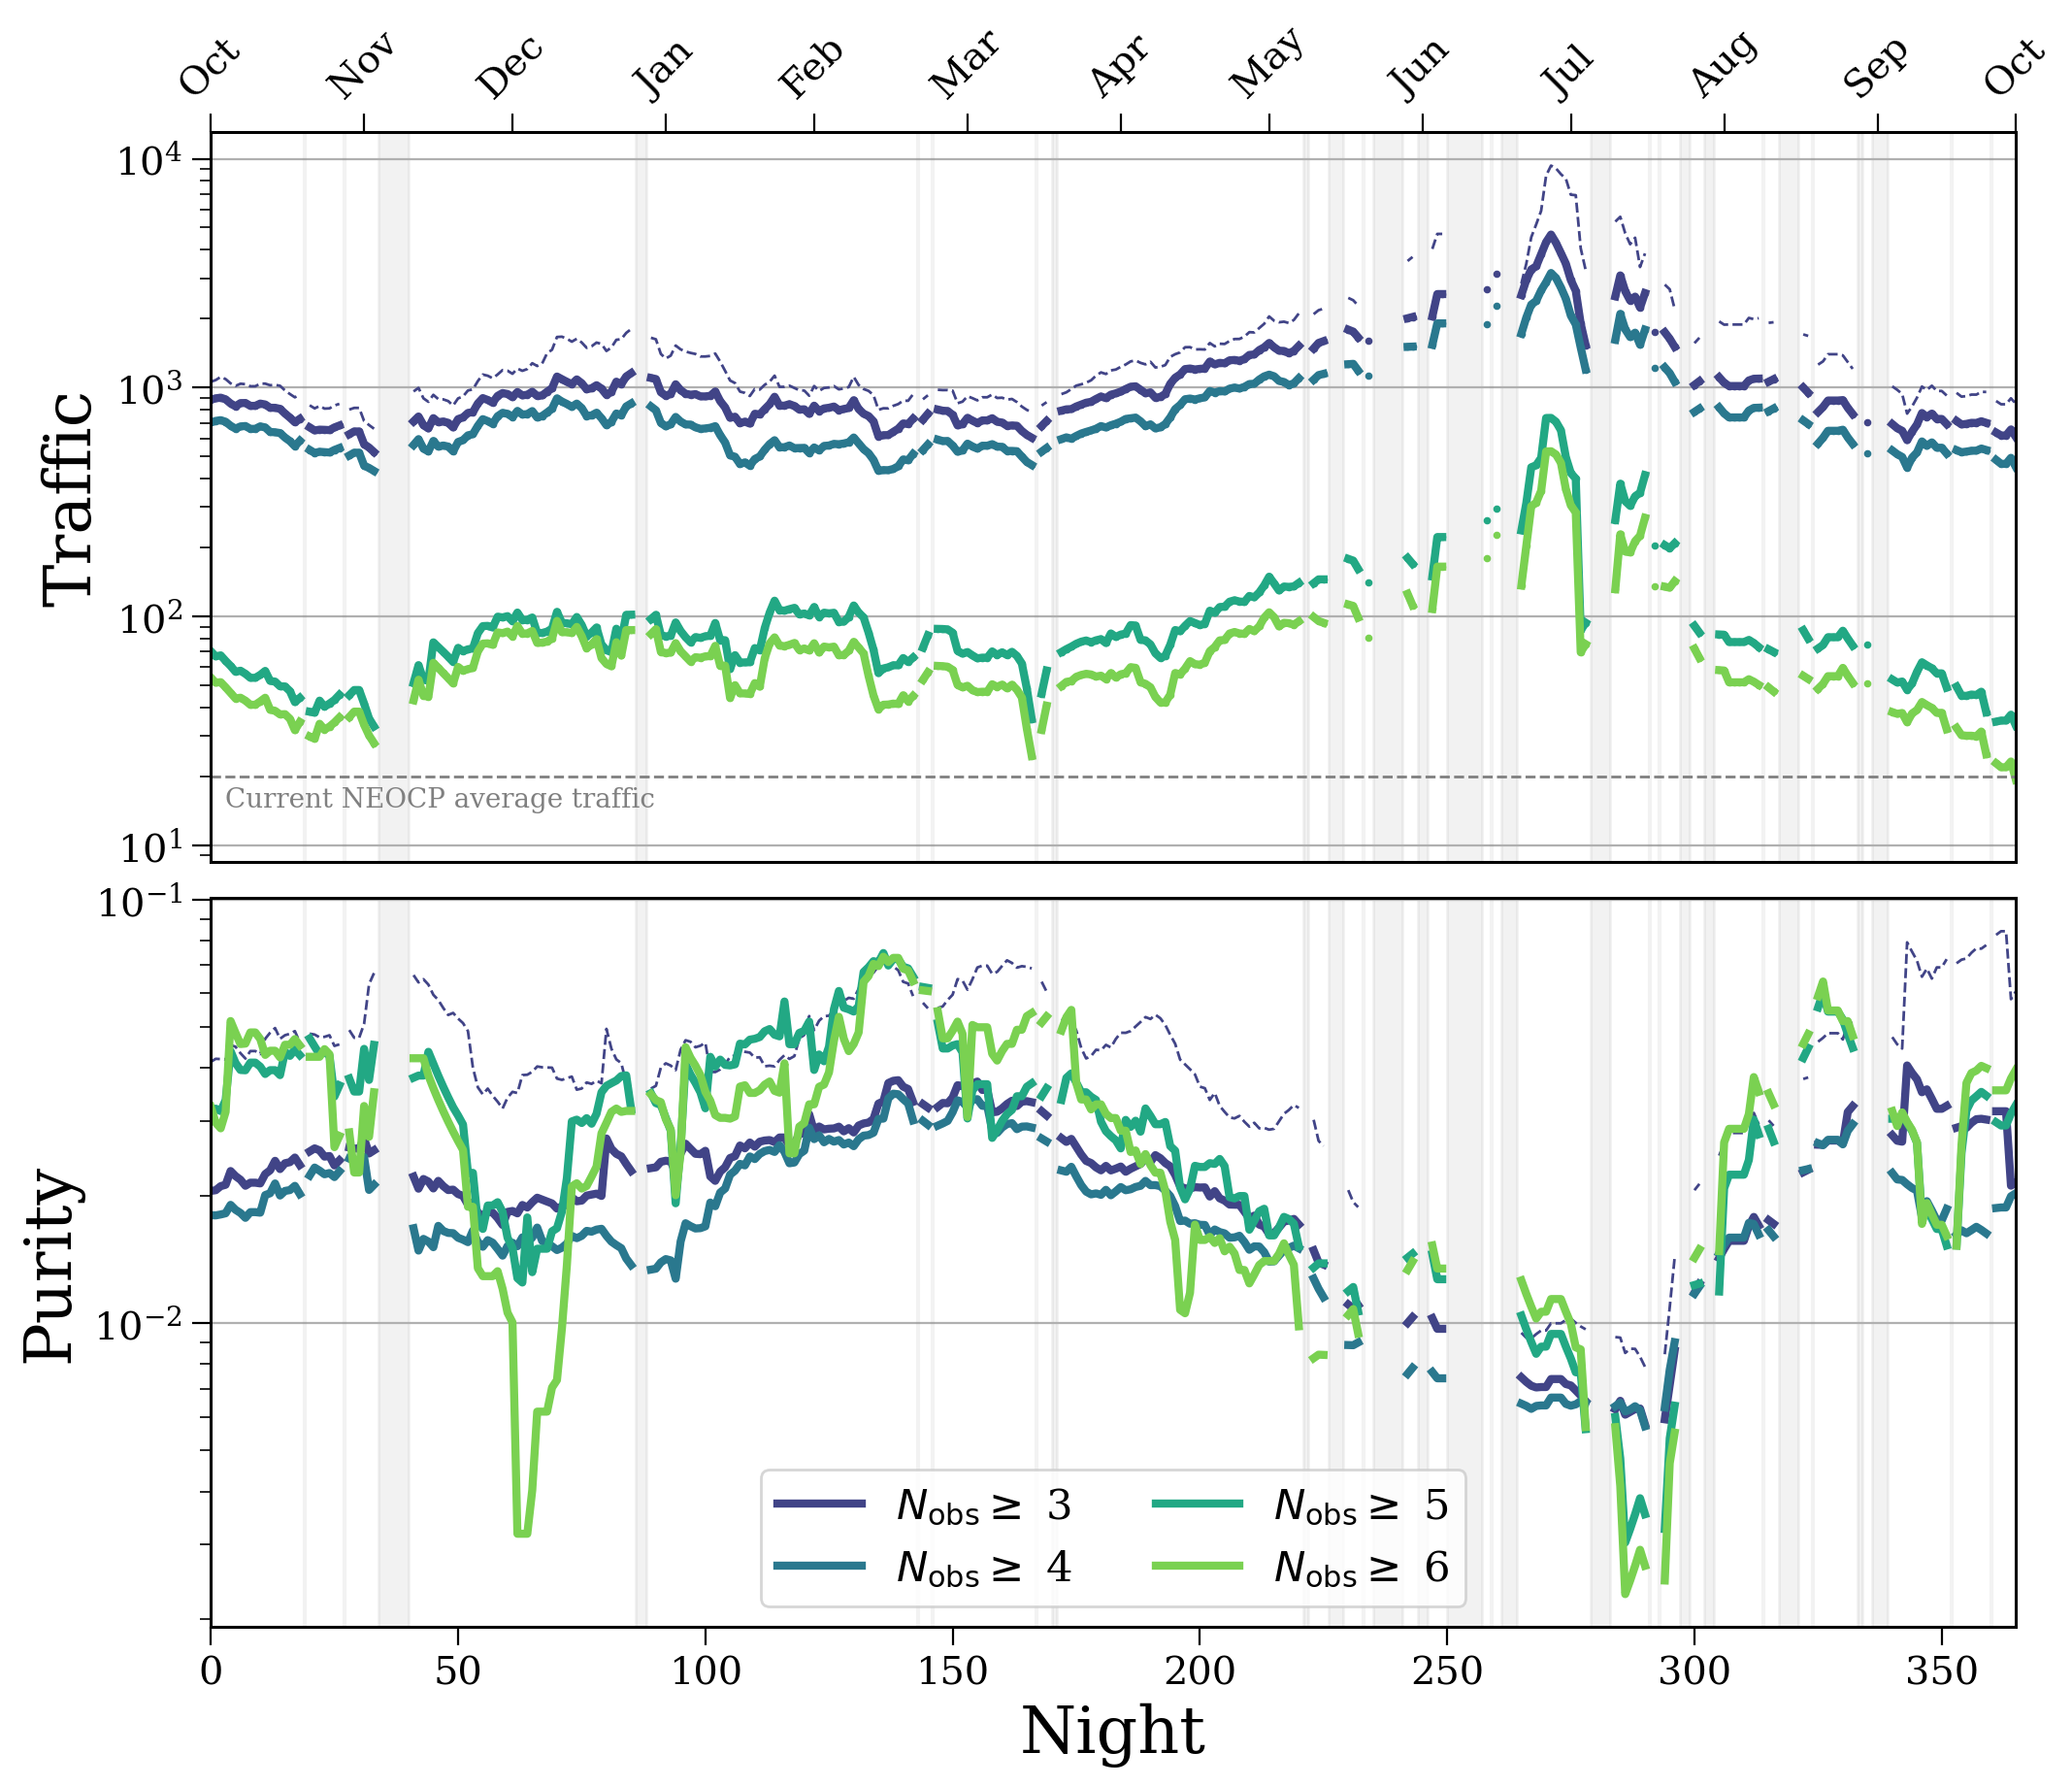

In [85]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05)

colours = [plt.get_cmap("viridis", len(n_obs_list) + 2)(i + 1) for i in range(len(n_obs_list))]
lw = 3

smoothing_window = 10

peak_range = [260, 290]


for i in range(len(n_obs_list)):
    t = weekly_mean(total_traffic.T[i + 1], bad_weather, size=smoothing_window)
    t_spiky = weekly_mean(total_traffic.T[i + 1], bad_weather, size=3)
    axes[0].plot(nights, np.where((nights < peak_range[0]) | (nights > peak_range[1]), t, t_spiky),
                 color=colours[i], lw=3, marker="o", markersize=np.sqrt(3))


t = weekly_mean(total_traffic.T[0], bad_weather, size=smoothing_window)
t_spiky = weekly_mean(total_traffic.T[0], bad_weather, size=3)
axes[0].plot(nights, np.where((nights < peak_range[0]) | (nights > peak_range[1]), t, t_spiky),
             color=colours[0], lw=1, linestyle="--")

axes[0].set_ylabel("Traffic")
axes[0].set_yscale("log")

axes[1].plot(nights, weekly_mean(purity.T[0], bad_weather, size=smoothing_window),
             #label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[0]}, all $m$",
             color=colours[0], lw=1, linestyle="--")
for i in range(len(n_obs_list)):
    axes[1].plot(nights, weekly_mean(purity.T[i + 1], bad_weather, size=smoothing_window),
                 label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[i]}",
                 color=colours[i], lw=3)
    
axes[1].set_yscale("log")
axes[1].set_xlabel("Night")
axes[1].set_ylabel("Purity")
    
leg = axes[1].legend(loc="lower center", ncol=2, fontsize=0.65*fs)#, bbox_to_anchor=(0.3, 1))
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(5.0)

labels = ["October", "November", "December", "January", "February",
          "March", "April", "May", "June", "July", "August", "September", "October"]
labels_short = [label[:3] for label in labels]
days = [0 for label in labels]
for i, month in enumerate(range(3, 16)):
    act_month, year = month % 12, month // 12
    if act_month == 0:
        act_month = 12
        year = 0
    days[i] = (date(2022 + year, act_month, 1) - date(2022, 3, 1)).days
    

axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top') 
    
axes[0].set_xticks(days)
axes[0].set_xticklabels(labels_short, rotation=45)

for ax in axes:
    ax.set_xlim(0, 365)
    ax.grid(axis="y")
    
    # loop over every day of bad weather
    i = 0
    while i < len(bad_weather):
        # if this is not the last entry and the subsequent entry is a contiguous block of nights
        if i < len(bad_weather) - 1 and bad_weather[i + 1] - bad_weather[i] == 1:
            # track the lower edge of the bad weather gap
            gap_low = bad_weather[i]
            i += 1
            while bad_weather[i] - bad_weather[i - 1] == 1 and i < len(bad_weather) - 1:
                i += 1
            gap_high = bad_weather[i - 1]
            
            ax.axvspan(gap_low, gap_high, color="grey", alpha=0.1)
        else:
            ax.axvline(bad_weather[i], color="grey", alpha=0.1)
            i += 1
            
axes[0].axhline(20, color="grey", linestyle="--", lw=1)
axes[0].annotate("Current NEOCP average traffic", xy=(3, 18), ha="left", va="top", color="grey", zorder=10)
            
# plt.savefig("../paper/figures/traffic_purity.pdf", format="pdf", bbox_inches="tight")

plt.show()

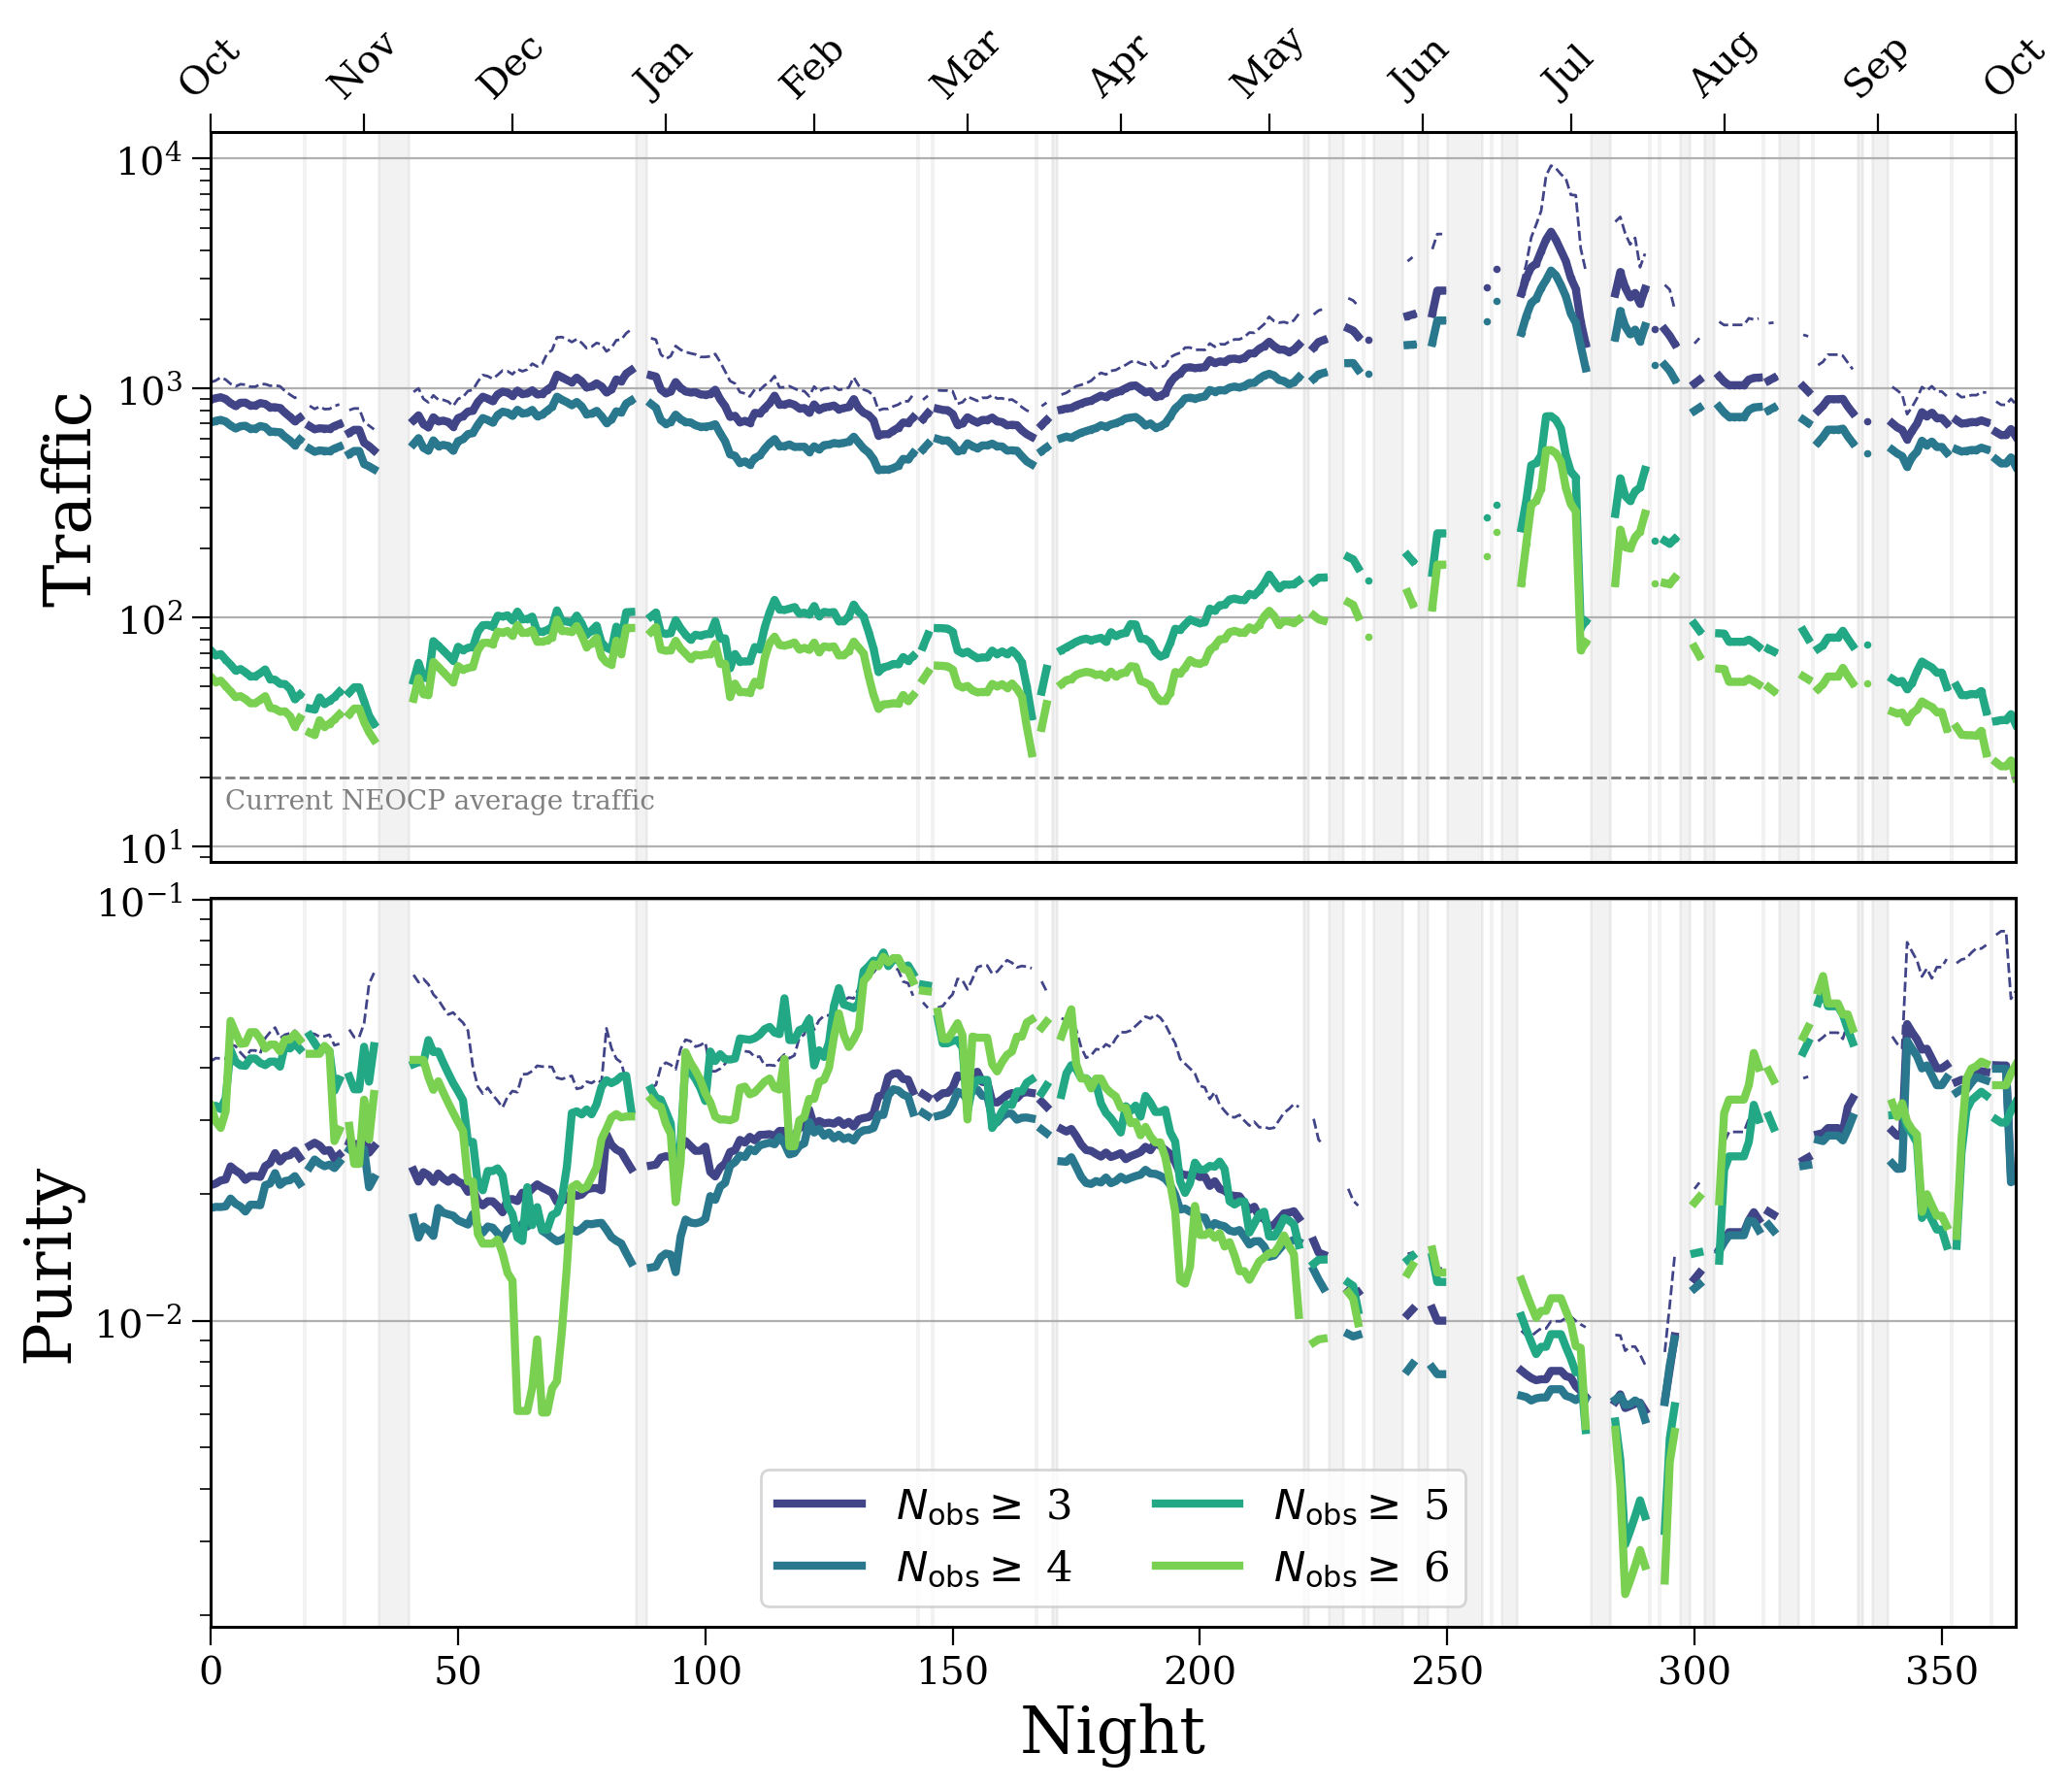

In [234]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05)

colours = [plt.get_cmap("viridis", len(n_obs_list) + 2)(i + 1) for i in range(len(n_obs_list))]
lw = 3

smoothing_window = 10

peak_range = [260, 290]


for i in range(len(n_obs_list)):
    t = weekly_mean(total_traffic.T[i + 1], bad_weather, size=smoothing_window)
    t_spiky = weekly_mean(total_traffic.T[i + 1], bad_weather, size=3)
    axes[0].plot(nights, np.where((nights < peak_range[0]) | (nights > peak_range[1]), t, t_spiky),
                 color=colours[i], lw=3, marker="o", markersize=np.sqrt(3))


t = weekly_mean(total_traffic.T[0], bad_weather, size=smoothing_window)
t_spiky = weekly_mean(total_traffic.T[0], bad_weather, size=3)
axes[0].plot(nights, np.where((nights < peak_range[0]) | (nights > peak_range[1]), t, t_spiky),
             color=colours[0], lw=1, linestyle="--")

axes[0].set_ylabel("Traffic")
axes[0].set_yscale("log")

axes[1].plot(nights, weekly_mean(purity.T[0], bad_weather, size=smoothing_window),
             #label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[0]}, all $m$",
             color=colours[0], lw=1, linestyle="--")
for i in range(len(n_obs_list)):
    axes[1].plot(nights, weekly_mean(purity.T[i + 1], bad_weather, size=smoothing_window),
                 label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[i]}",
                 color=colours[i], lw=3)
    
axes[1].set_yscale("log")
axes[1].set_xlabel("Night")
axes[1].set_ylabel("Purity")
    
leg = axes[1].legend(loc="lower center", ncol=2, fontsize=0.65*fs)#, bbox_to_anchor=(0.3, 1))
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(5.0)

labels = ["October", "November", "December", "January", "February",
          "March", "April", "May", "June", "July", "August", "September", "October"]
labels_short = [label[:3] for label in labels]
days = [0 for label in labels]
for i, month in enumerate(range(3, 16)):
    act_month, year = month % 12, month // 12
    if act_month == 0:
        act_month = 12
        year = 0
    days[i] = (date(2022 + year, act_month, 1) - date(2022, 3, 1)).days
    

axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top') 
    
axes[0].set_xticks(days)
axes[0].set_xticklabels(labels_short, rotation=45)

for ax in axes:
    ax.set_xlim(0, 365)
    ax.grid(axis="y")
    
    # loop over every day of bad weather
    i = 0
    while i < len(bad_weather):
        # if this is not the last entry and the subsequent entry is a contiguous block of nights
        if i < len(bad_weather) - 1 and bad_weather[i + 1] - bad_weather[i] == 1:
            # track the lower edge of the bad weather gap
            gap_low = bad_weather[i]
            i += 1
            while bad_weather[i] - bad_weather[i - 1] == 1 and i < len(bad_weather) - 1:
                i += 1
            gap_high = bad_weather[i - 1]
            
            ax.axvspan(gap_low, gap_high, color="grey", alpha=0.1)
        else:
            ax.axvline(bad_weather[i], color="grey", alpha=0.1)
            i += 1
            
axes[0].axhline(20, color="grey", linestyle="--", lw=1)
axes[0].annotate("Current NEOCP average traffic", xy=(3, 18), ha="left", va="top", color="grey", zorder=10)
            
# plt.savefig("../paper/figures/traffic_purity.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Magnitudes of NEOs

In [293]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [339]:
total_traffic_unfindable.sum(axis=0)

array([50965, 15845, 11996,  1940,  1483])

In [342]:
neo_counts_unfindable.sum(axis=0)

array([2248,  375,  271,   43,   35])

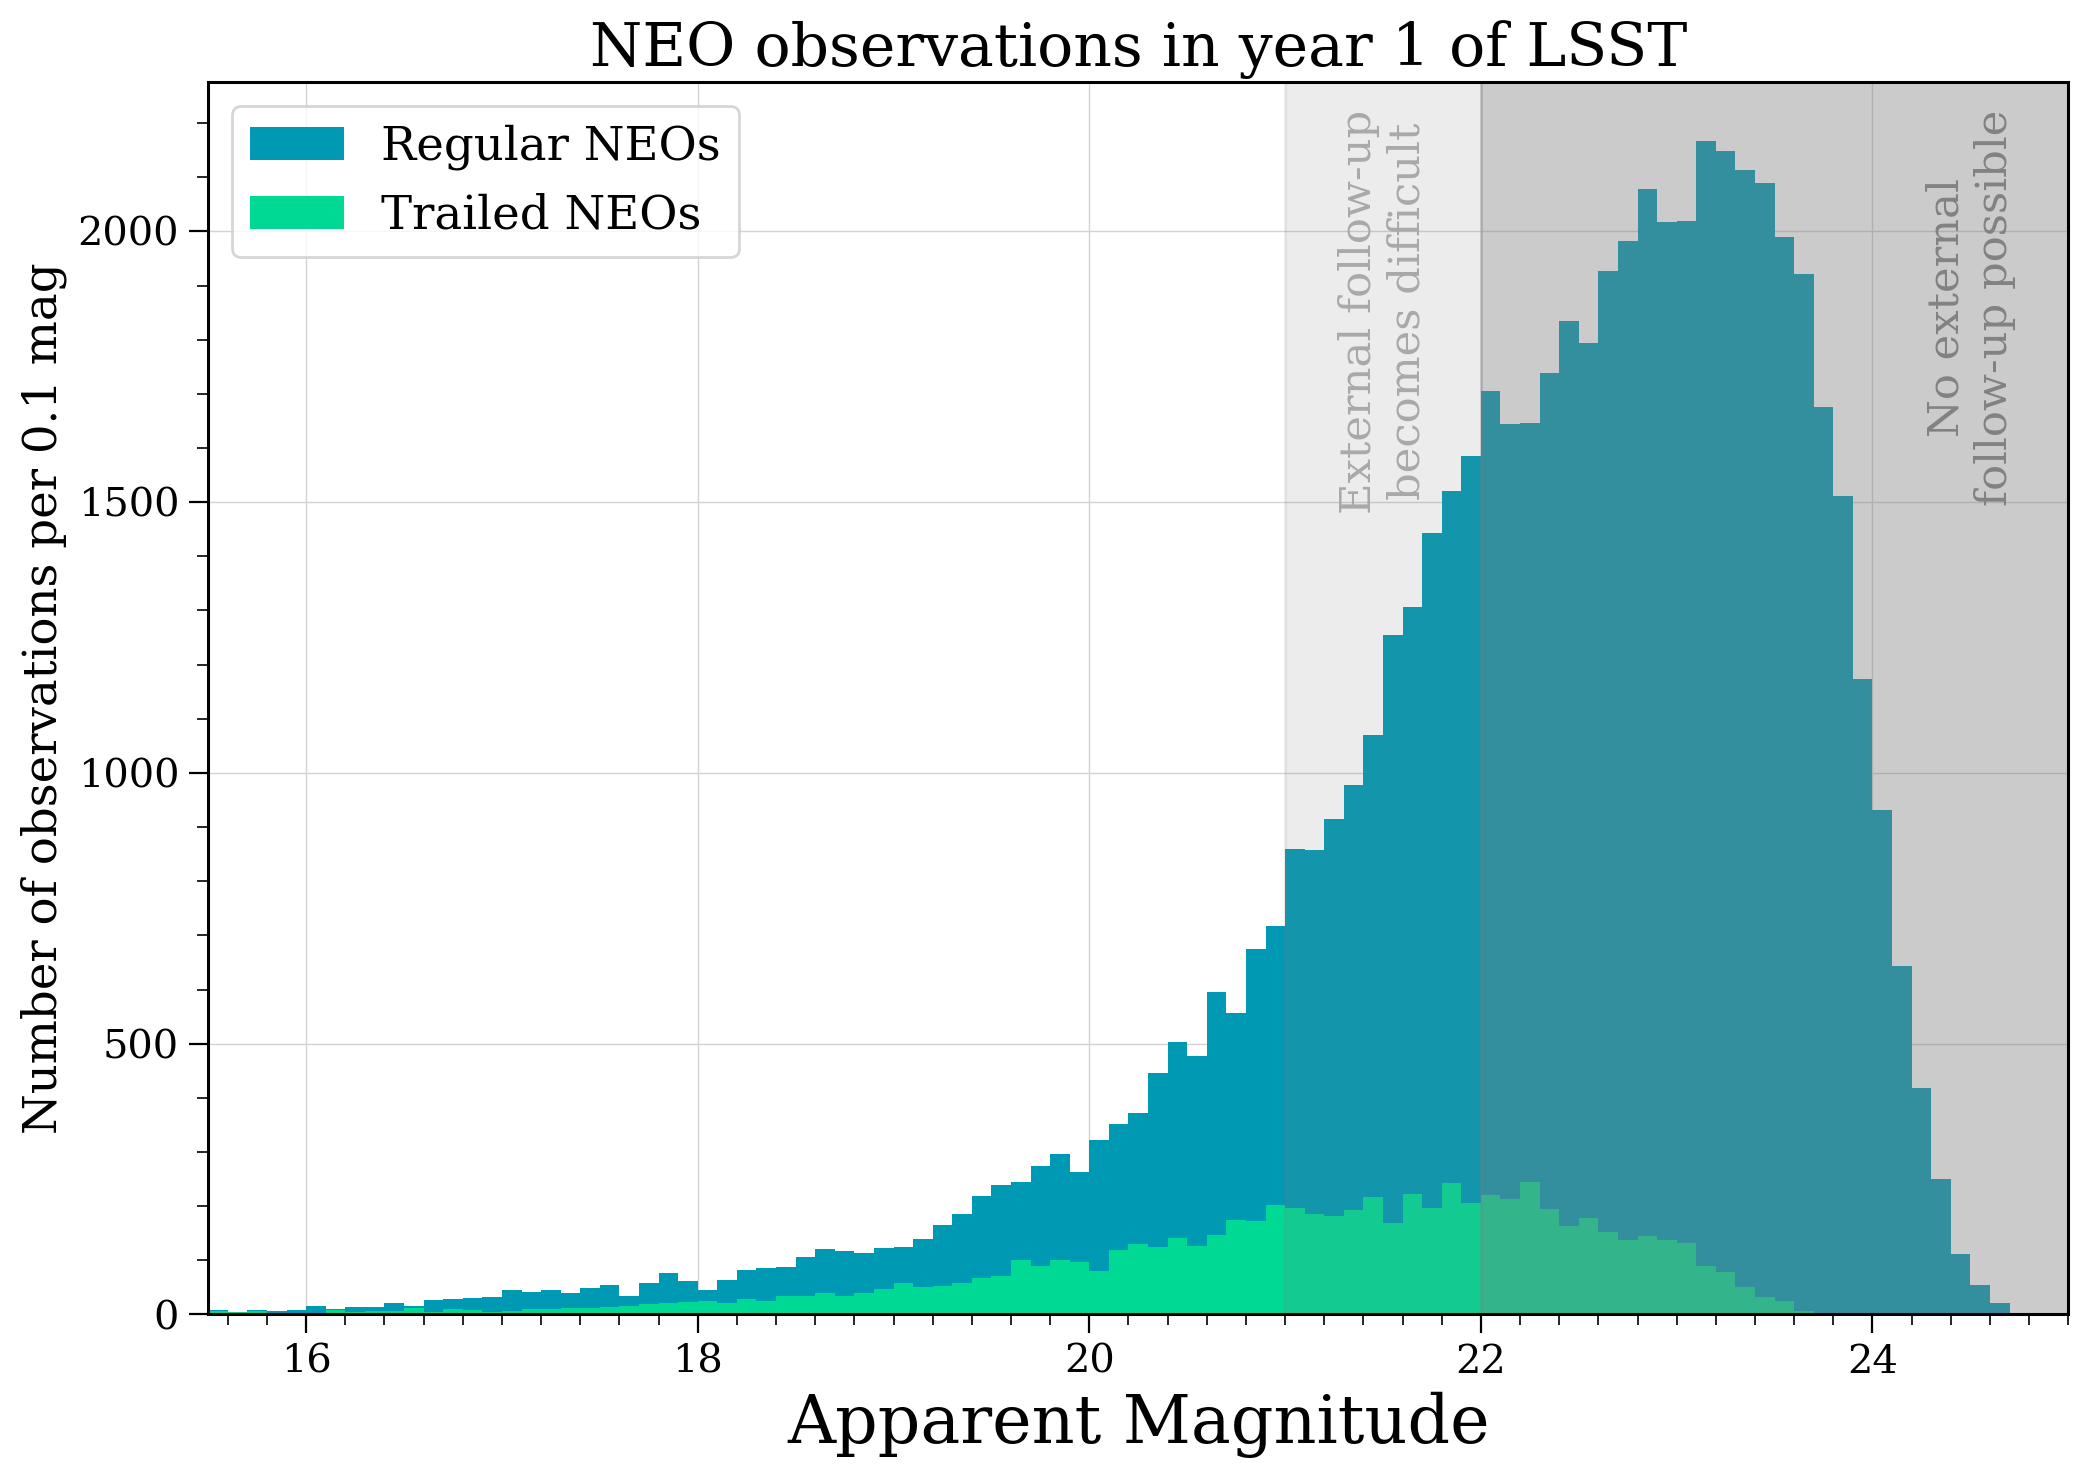

In [337]:
plt.figure(figsize=(12, 8))
plt.hist(all_mags, bins=np.arange(15.5, 25, 0.1), label="Regular NEOs",
         color=plt.get_cmap("winter")(0.6), histtype="stepfilled")#, edgecolor=plt.get_cmap("winter")(0.5))
plt.hist(fast_mags, bins=np.arange(15.5, 25, 0.1), label="Trailed NEOs",
         color=plt.get_cmap("winter")(0.85), histtype="stepfilled")#, edgecolor=plt.get_cmap("winter")(0.8))
plt.axvspan(21, 26, color="grey", alpha=0.15)#, lw=3, linestyle="--")
plt.axvspan(22, 26, color="grey", alpha=0.3)#, lw=3, linestyle="--")
plt.legend(fontsize=0.7*fs)
plt.xlim(15.5, 25)
plt.xlabel("Apparent Magnitude")
plt.ylabel("Number of observations per 0.1 mag", fontsize=0.7*fs)
plt.title("NEO observations in year 1 of LSST", fontsize=0.9*fs)

plt.annotate("External follow-up\nbecomes difficult", xy=(21.5, 2225),
             ha="center", va="top", rotation=90, color="darkgrey", zorder=10, fontsize=0.65*fs)
plt.annotate("No external\nfollow-up possible", xy=(24.5, 2225),
             ha="center", va="top", rotation=90, color="#828282", zorder=10, fontsize=0.65*fs)

plt.ylim(top=2275)
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.2))
plt.gca().yaxis.set_minor_locator(MultipleLocator(100))

for x in plt.xticks()[0]:
    plt.axvline(x, zorder=-1, color="lightgrey", lw=0.5)
for y in plt.yticks()[0]:
    plt.axhline(y, zorder=-1, color="lightgrey", lw=0.5)

plt.savefig("../paper/figures/neo_magnitudes.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [305]:
f'{(all_mags < 22).sum() / len(all_mags) * 100:1.0f}% of regular brighter than 22'

'34% of regular brighter than 22'

In [306]:
f'{(fast_mags < 22).sum() / len(fast_mags) * 100:1.0f}% of trailed brighter than 22'

'68% of trailed brighter than 22'

# Traffic and Purity with future knowledge

Let's apply `difi` to see which ones are findable

In [40]:
def get_findable_hex_ids(path="neo/", file_ids=range(22)):
                         
    obs_dfs = [pd.read_hdf(path + f"filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")[["FieldMJD", "night"]]
               for i in file_ids]
    all_obs = pd.concat(obs_dfs)
    all_obs["obs_id"] = np.arange(len(all_obs))
    all_obs.reset_index(inplace=True)
    
    print("Obs file done")

    findable_hex_ids = None

    all_truths, findable_obs, summary = difi.analyzeObservations(
        observations=all_obs,
        classes=None,
        metric="nightly_linkages",
        column_mapping={"obs_id": "obs_id", "truth": "hex_id", "night": "night", "time": "FieldMJD"}
    )

    findable_hex_ids = all_truths[all_truths["findable"] == 1]["hex_id"].values

    return findable_hex_ids

In [23]:
%%time
findable_neo_hex_ids = get_findable_hex_ids()

Obs file done
CPU times: user 12.3 s, sys: 423 ms, total: 12.8 s
Wall time: 12.8 s


In [41]:
%%time
findable_mba_hex_ids = get_findable_hex_ids(path="mba/")

Obs file done
CPU times: user 31min 11s, sys: 2min 36s, total: 33min 48s
Wall time: 32min


In [42]:
unique_findable_neo_hex_ids = np.unique(findable_neo_hex_ids)
unique_findable_mba_hex_ids = np.unique(findable_mba_hex_ids)

In [43]:
np.save("unique_findable_neo_hex_ids_linked.npy", unique_findable_neo_hex_ids)
np.save("unique_findable_mba_hex_ids_linked.npy", unique_findable_mba_hex_ids)

In [44]:
unique_findable_neo_hex_ids = np.load("unique_findable_neo_hex_ids_linked.npy", allow_pickle=True)
unique_findable_mba_hex_ids = np.load("unique_findable_mba_hex_ids_linked.npy", allow_pickle=True)

In [45]:
def get_counts(path="neo/", n_obs_list=[3, 3, 4, 5, 6], last_night=373,
               remove_streaks=True, findable_hex_ids=None):
    counts = np.zeros((last_night, len(n_obs_list))).astype(int)
    n_too_faint = 0
    
    for file in range(22):
        print(f"file {file}")
        visit_file = pd.read_hdf(path + f"filtered_visit_scores_{file:03d}.h5")
        nights = visit_file["night"].unique()
        for night in nights:
            if night >= last_night:
                break
            nightly_visit = visit_file[visit_file["night"] == night]
            grouped = nightly_visit.groupby("hex_id").first()

            if path == "neo/" and remove_streaks:
                no_streaks = ~(np.isin(grouped["ObjID"], neo_streakers["ObjID"][neo_streakers["night"] == night]))
                grouped = grouped[no_streaks]

            if findable_hex_ids is not None:
                grouped = grouped[~grouped.index.isin(findable_hex_ids)]
                
            out_v_mag = magnitudes.convert_colour_mags(grouped["MaginFilter"].values, out_colour="V", in_colour=grouped["filter"].values)
            
            for i, n_obs in enumerate(n_obs_list):
                no_mag_mask = (grouped["n_obs"] >= n_obs) & (grouped["scores"] >= 65)
                full_mask = no_mag_mask & (out_v_mag <= 22)
                
                if i == 0:
                    n_too_faint += (no_mag_mask.sum() - full_mask.sum())
                    counts[night, i] += no_mag_mask.sum()
                else:
                    counts[night, i] += full_mask.sum()

    print(n_too_faint)
                    
    return counts

In [46]:
neo_counts_unfindable = get_counts(findable_hex_ids=unique_findable_neo_hex_ids)

file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19
file 20
file 21
1873


In [47]:
%%time
mba_counts_unfindable = get_counts(path="mba/", findable_hex_ids=unique_findable_mba_hex_ids)

file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19
file 20
file 21
33247
CPU times: user 6min 3s, sys: 18.6 s, total: 6min 22s
Wall time: 6min 34s


In [48]:
total_traffic_unfindable = neo_counts_unfindable + mba_counts_unfindable

In [49]:
purity_unfindable = neo_counts_unfindable / total_traffic_unfindable

/tmp/ipykernel_60809/1320287732.py:1: RuntimeWarning: invalid value encountered in true_divide
  purity_unfindable = neo_counts_unfindable / total_traffic_unfindable


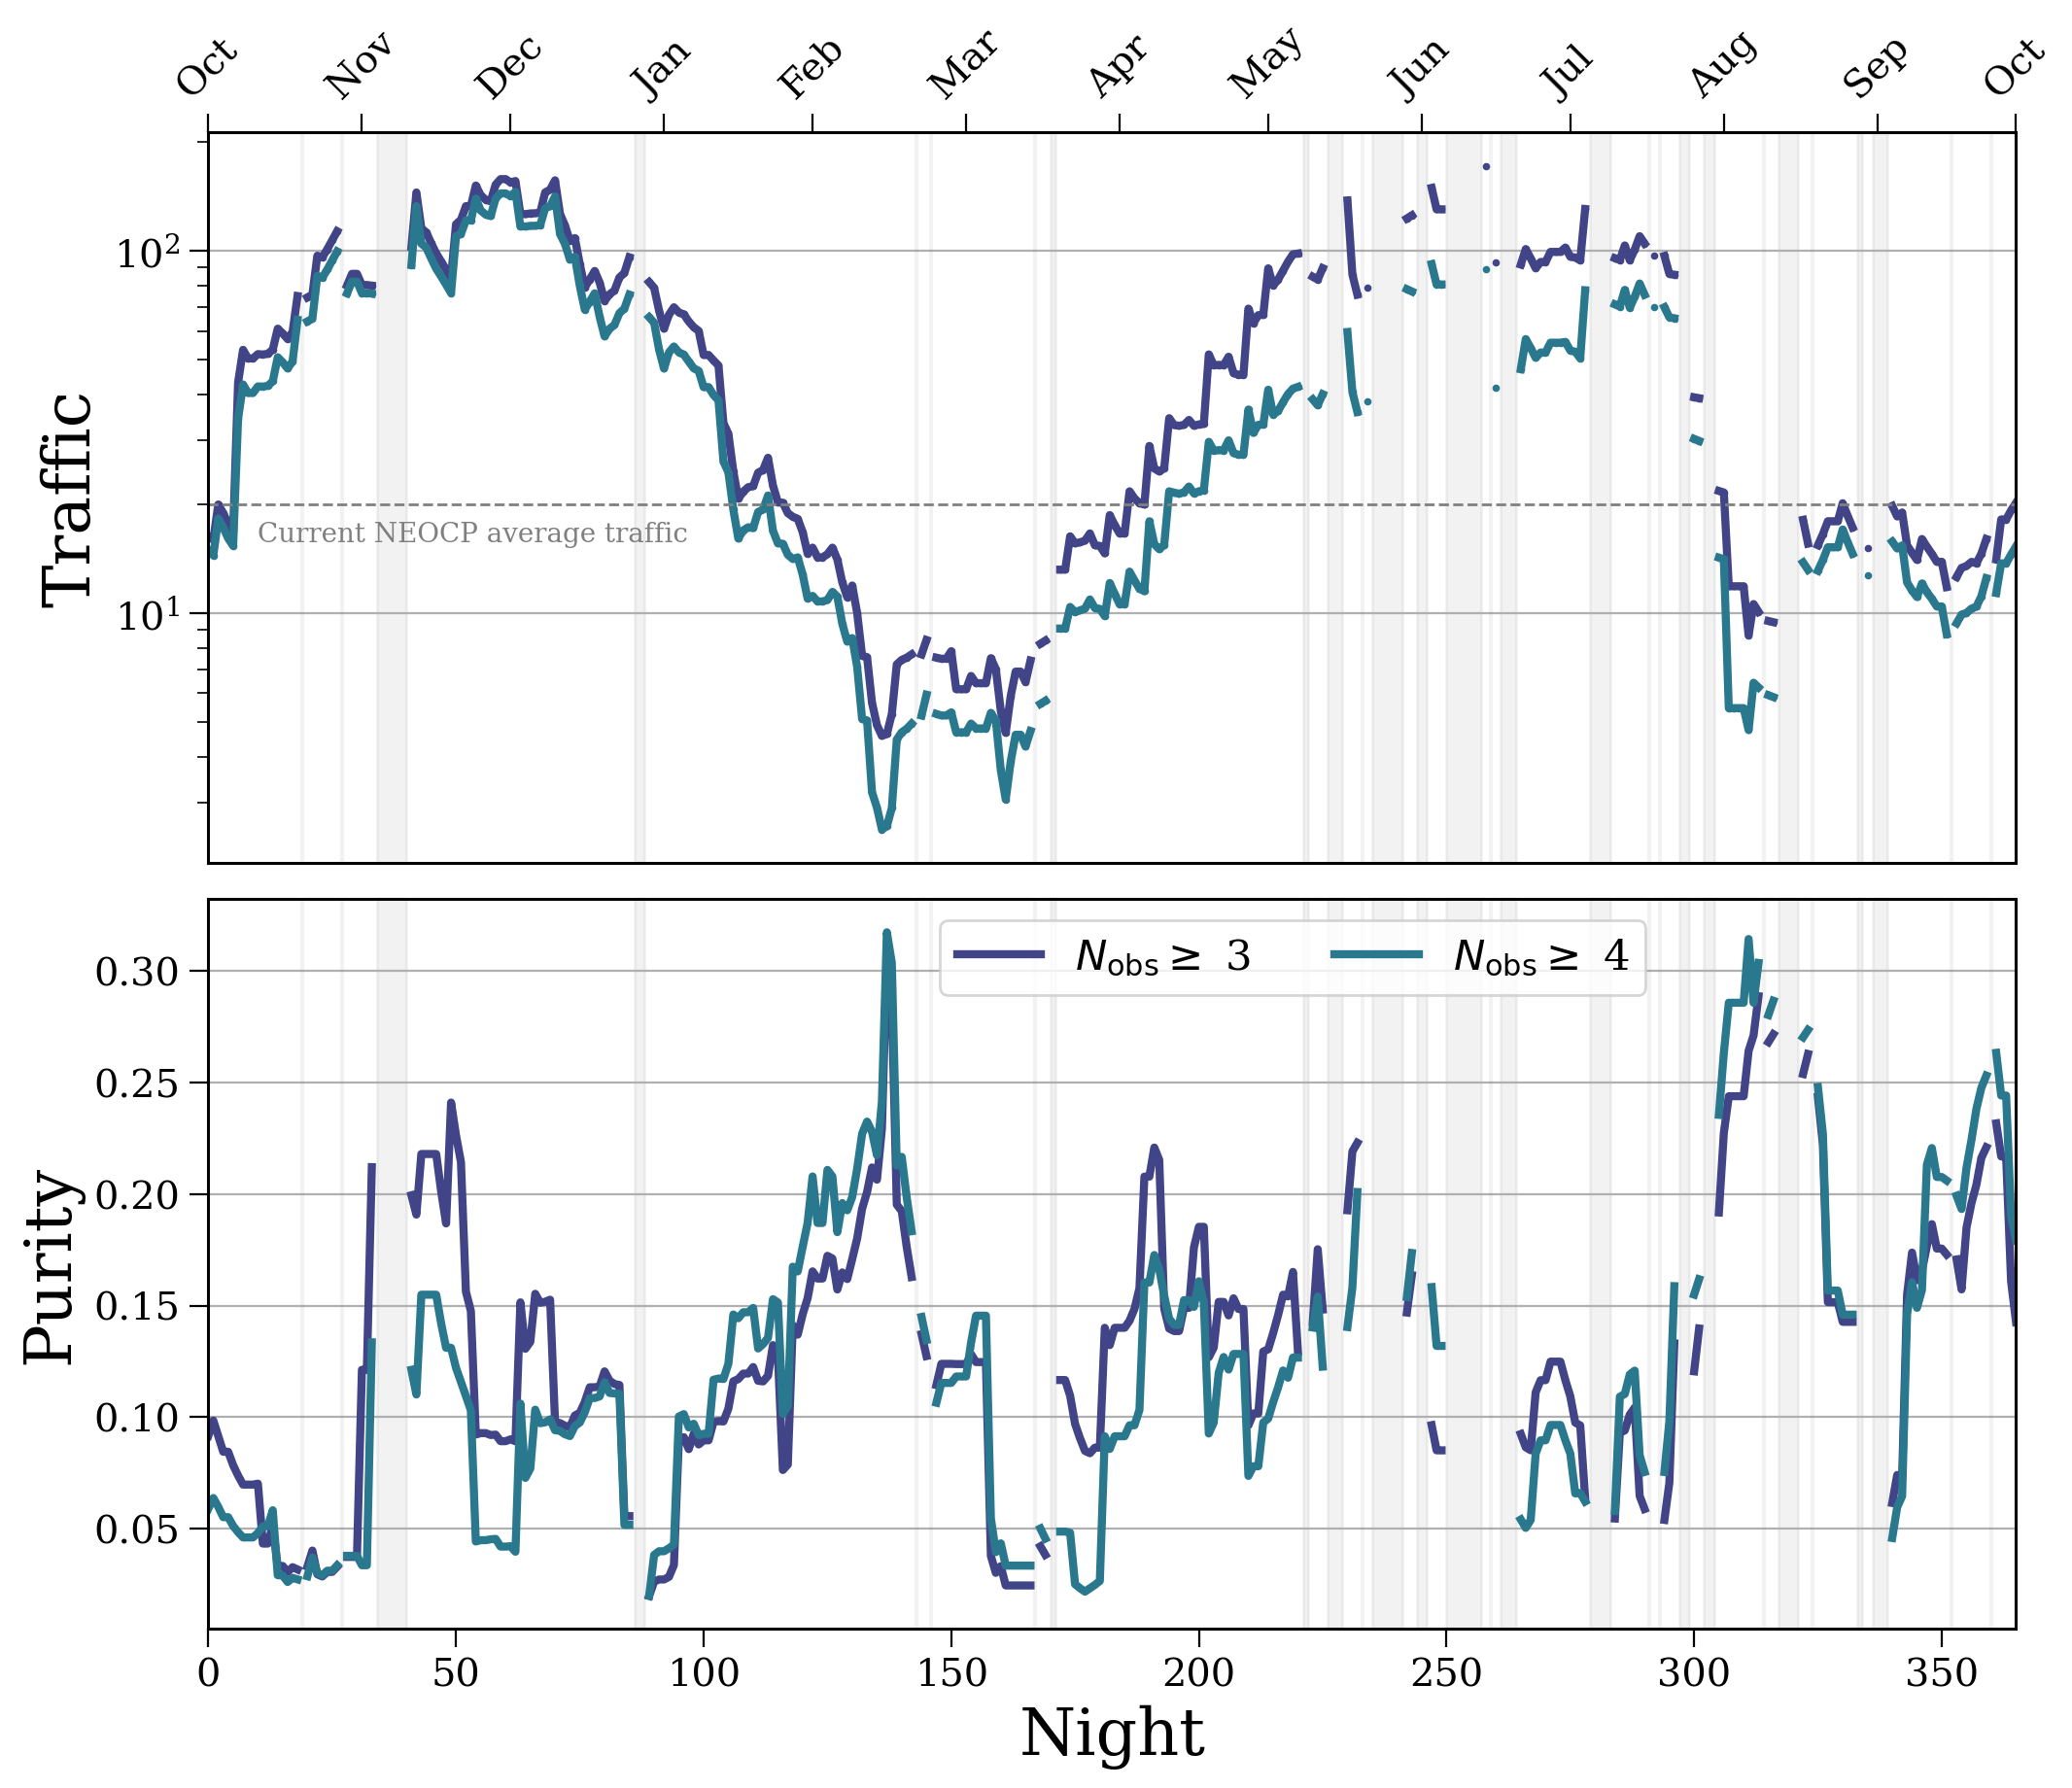

In [241]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05)

colours = [plt.get_cmap("viridis", len(n_obs_list) + 2)(i + 1) for i in range(len(n_obs_list))]
lw = 3

n_obs_range = [0, 1]

smoothing_window = 10

for i in n_obs_range:
    axes[0].plot(nights, weekly_mean(total_traffic_unfindable.T[i + 1],
                                     bad_weather, size=smoothing_window),
                 color=colours[i], lw=3, marker="o", markersize=np.sqrt(3))
# axes[0].plot(nights, weekly_mean(total_traffic_unfindable.T[0], bad_weather, size=smoothing_window),
#              color=colours[0], lw=1, linestyle="--")
axes[0].set_ylabel("Traffic")
axes[0].set_yscale("log")

# axes[1].plot(nights, weekly_mean(purity_unfindable.T[0], bad_weather, size=smoothing_window),
#              label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[0]}, all $m$",
#              color=colours[0], lw=1, linestyle="--")
for i in n_obs_range:
    axes[1].plot(nights, weekly_mean(purity_unfindable.T[i + 1],
                                     bad_weather, size=smoothing_window),
                 label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[i]}",
                 color=colours[i], lw=3)
    
# axes[1].set_yscale("log")
axes[1].set_xlabel("Night")
axes[1].set_ylabel("Purity")
    
leg = axes[1].legend(loc="upper center", ncol=2, fontsize=0.65*fs, bbox_to_anchor=(0.6, 1))
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(5.0)

labels = ["October", "November", "December", "January", "February",
          "March", "April", "May", "June", "July", "August", "September", "October"]
labels_short = [label[:3] for label in labels]
days = [0 for label in labels]
for i, month in enumerate(range(3, 16)):
    act_month, year = month % 12, month // 12
    if act_month == 0:
        act_month = 12
        year = 0
    days[i] = (date(2022 + year, act_month, 1) - date(2022, 3, 1)).days
    

axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top') 
    
axes[0].set_xticks(days)
axes[0].set_xticklabels(labels_short, rotation=45)

for ax in axes:
    ax.set_xlim(0, 365)
    ax.grid(axis="y")
    
    # loop over every day of bad weather
    i = 0
    while i < len(bad_weather):
        # if this is not the last entry and the subsequent entry is a contiguous block of nights
        if i < len(bad_weather) - 1 and bad_weather[i + 1] - bad_weather[i] == 1:
            # track the lower edge of the bad weather gap
            gap_low = bad_weather[i]
            i += 1
            while bad_weather[i] - bad_weather[i - 1] == 1 and i < len(bad_weather) - 1:
                i += 1
            gap_high = bad_weather[i - 1]
            
            ax.axvspan(gap_low, gap_high, color="grey", alpha=0.1)
        else:
            ax.axvline(bad_weather[i], color="grey", alpha=0.1)
            i += 1
            
axes[0].axhline(20, color="grey", linestyle="--", lw=1)
axes[0].annotate("Current NEOCP average traffic", xy=(10, 18), ha="left", va="top", color="grey")
            
plt.savefig("../paper/figures/traffic_purity_unfindable.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [243]:
np.nanmean(purity_unfindable[:, 1])

0.12935538359581758

0.0
0.18078544304686048
0.0
0.16954457491474254


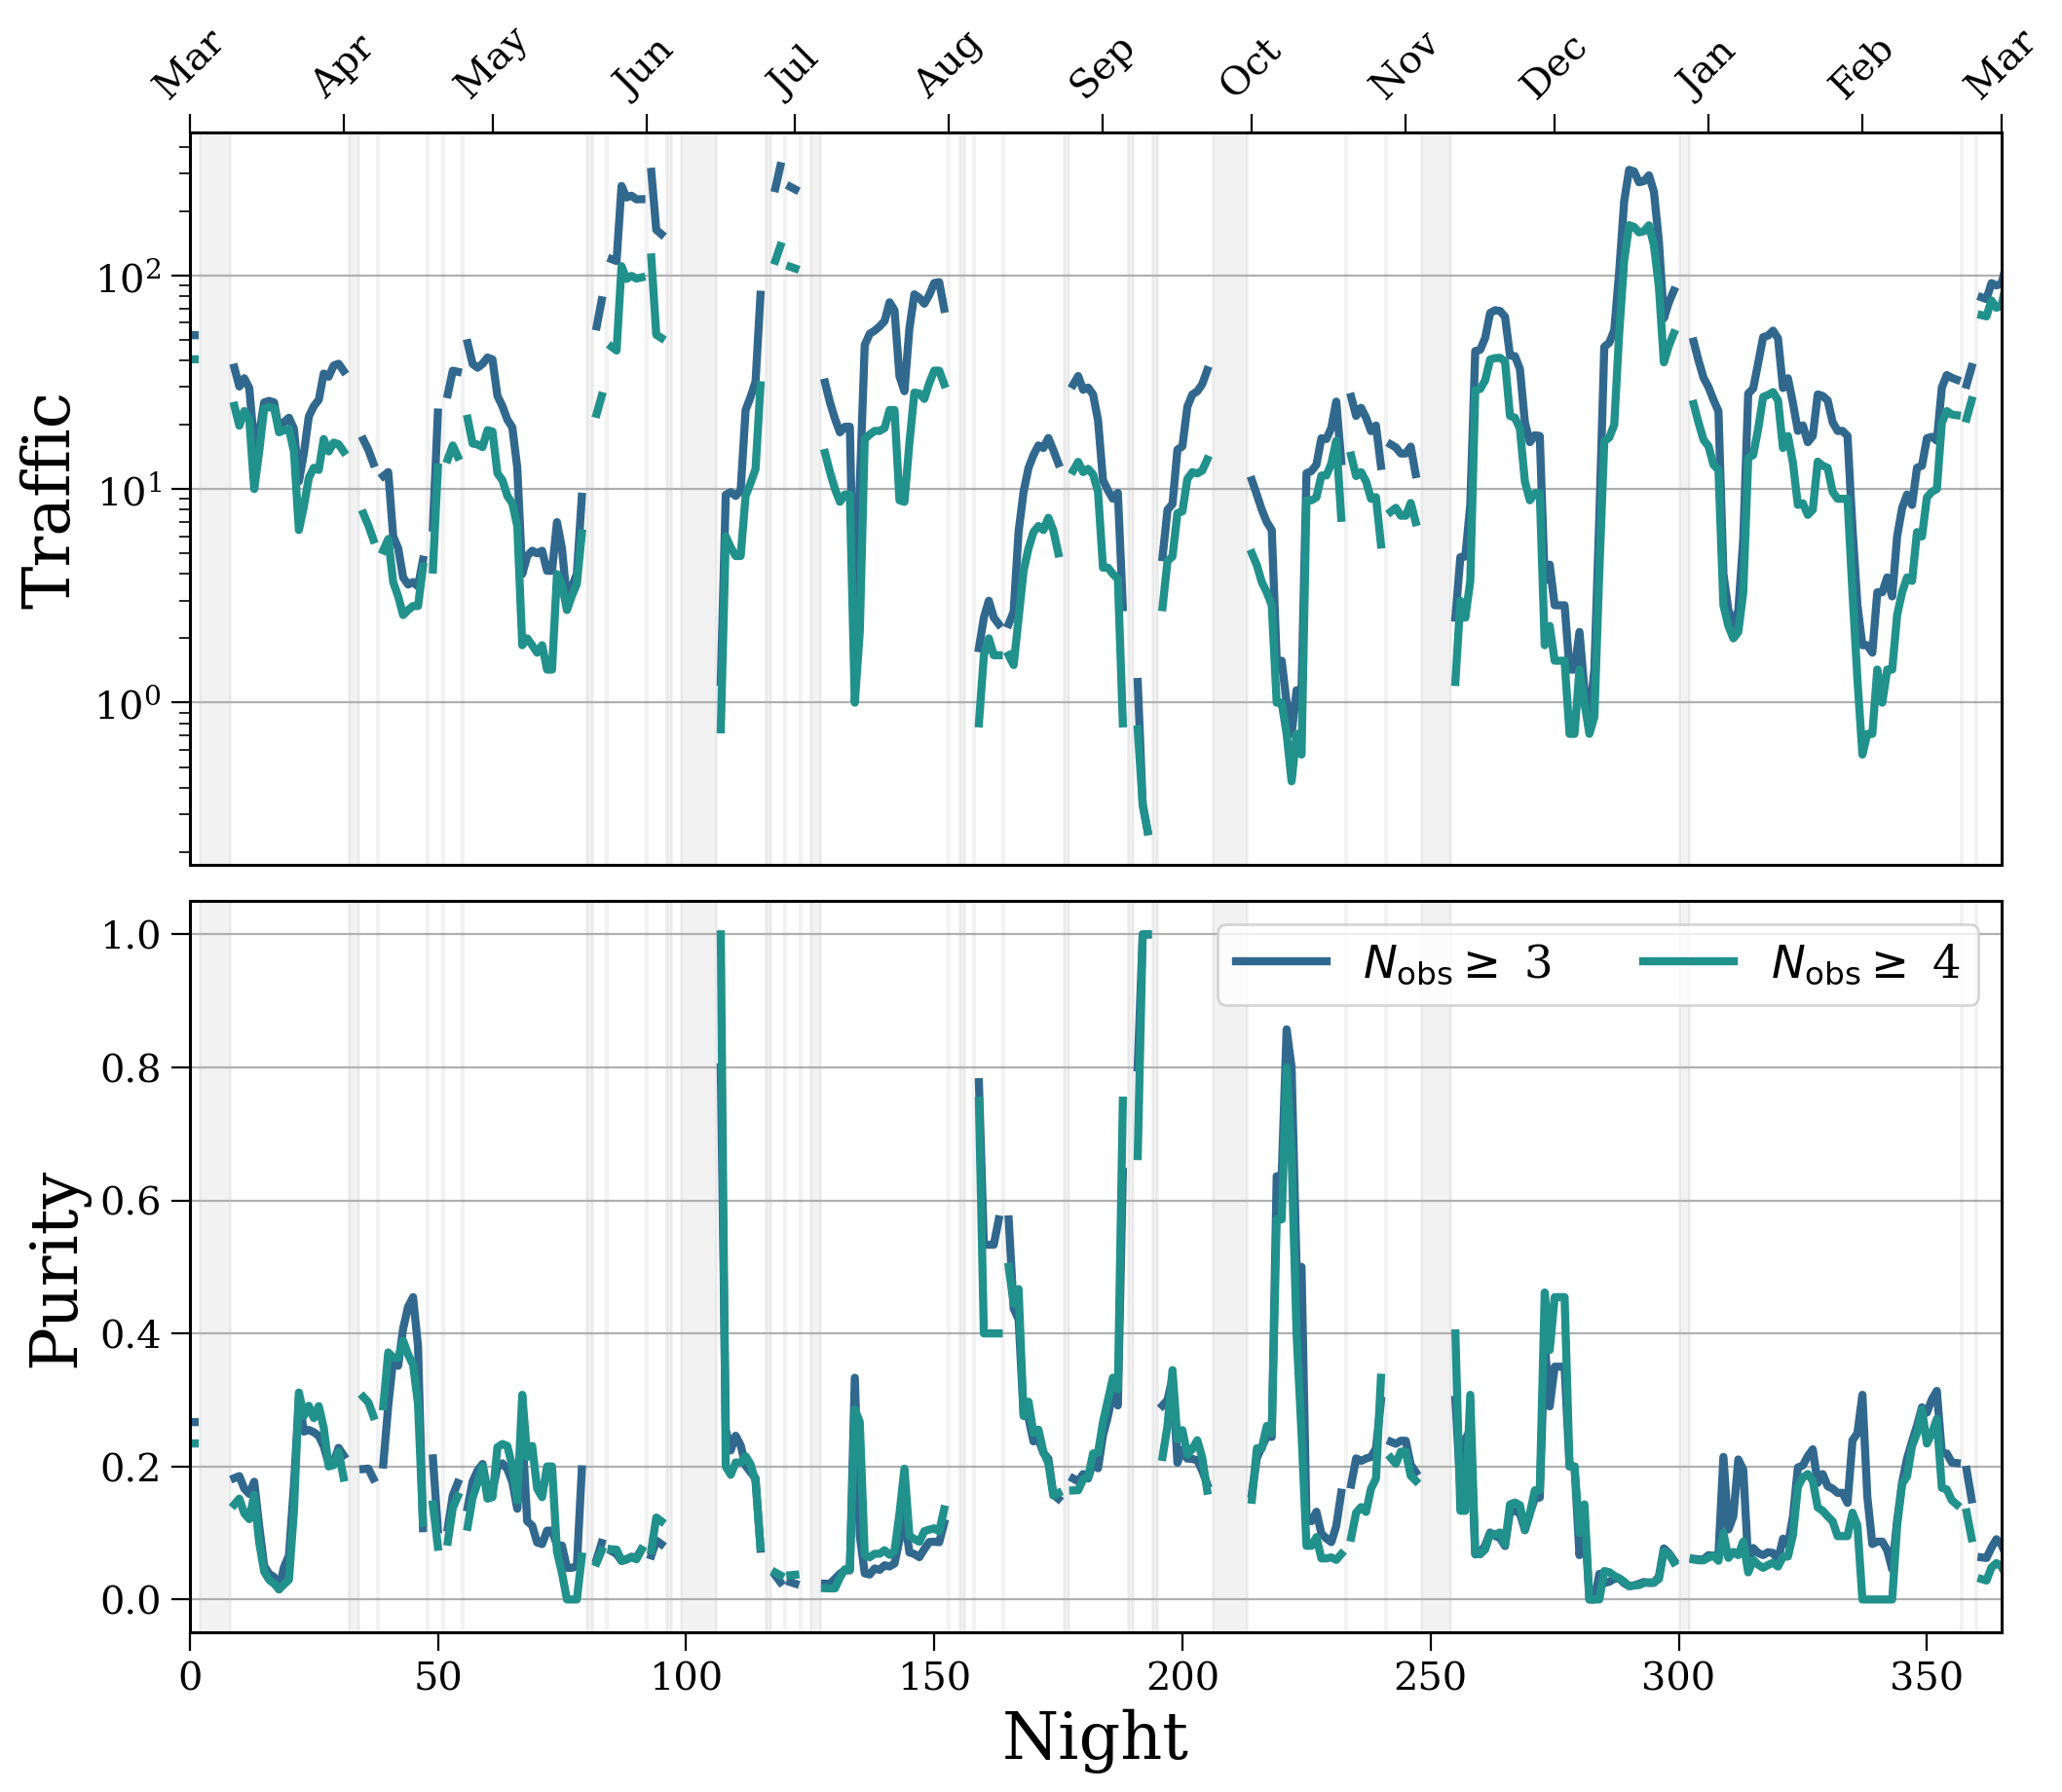

In [51]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05)

colours = [plt.get_cmap("viridis", len(n_obs_list) + 2)(i + 1) for i in range(len(n_obs_list))]
lw = 3

n_obs_range = [1, 2]

for i in n_obs_range:#range(len(n_obs_list)):
    axes[0].plot(nights, weekly_mean(total_traffic_unfindable.T[i], bad_weather),
                 color=colours[i], lw=3)
axes[0].set_ylabel("Traffic")
axes[0].set_yscale("log")

for i in n_obs_range:#range(len(n_obs_list)):
    purity = weekly_mean(neo_counts_unfindable.T[i], bad_weather) / weekly_mean(total_traffic_unfindable.T[i], bad_weather)
    axes[1].plot(nights, purity,
                 label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[i]}",
                 color=colours[i], lw=3)
    print(np.min(purity[np.logical_not(np.isnan(purity))]))
    print(np.mean(purity[np.logical_not(np.isnan(purity))]))
    
# axes[1].set_yscale("log")
axes[1].set_xlabel("Night")
axes[1].set_ylabel("Purity")

# leg = axes[0].legend(loc="center right", bbox_to_anchor=(1.32, 0))
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(5.0)
    
leg = axes[1].legend(loc="upper right", ncol=2, fontsize=0.7*fs)
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(5.0)

labels = ["March", "April", "May", "June", "July", "August", "September",
          "October", "November", "December", "January", "February", "March"]
labels_short = [label[:3] for label in labels]
days = [0 for label in labels]
for i, month in enumerate(range(3, 16)):
    act_month, year = month % 12, month // 12
    if act_month == 0:
        act_month = 12
        year = 0
    days[i] = (date(2022 + year, act_month, 1) - date(2022, 3, 1)).days
    

axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top') 
    
axes[0].set_xticks(days)
axes[0].set_xticklabels(labels_short, rotation=45)

for ax in axes:
    ax.set_xlim(0, 365)
    ax.grid(axis="y")
    
    i = 0
    while i < len(bad_weather):
        if i < len(bad_weather) - 1 and bad_weather[i + 1] - bad_weather[i] == 1:
            gap_low = bad_weather[i]
            i += 1
            while bad_weather[i] - bad_weather[i - 1] == 1 and i < len(bad_weather):
                i += 1
            gap_high = bad_weather[i - 1]
            
            ax.axvspan(gap_low, gap_high, color="grey", alpha=0.1)
        else:
            ax.axvline(bad_weather[i], color="grey", alpha=0.1)
            i += 1
            
plt.savefig("../paper/figures/traffic_purity_unfindable.pdf", format="pdf", bbox_inches="tight")

plt.show()

<hr height="10px">

# Sky projections

## Set up ecliptic plane

In [9]:
lon = coord.Angle(np.linspace(-180, 179.9, 1000)*u.degree)
lat = coord.Angle(np.zeros(1000)*u.degree)

ecliptic = coord.SkyCoord(lon=lon, lat=lat, frame='geocentrictrueecliptic').transform_to("icrs")
ecliptic.ra.radian = coord.Angle(ecliptic.ra).wrap_at('180d').radian

## Get RA/Dec

In [30]:
total_neo_obs = 0
for file in range(207):
    x = pd.read_hdf(f"/data/epyc/projects/jpl_survey_sim/10yrs/detections/march_start_v2.1/S0/visit-{int(file * 1e4):07}.h5")
    total_neo_obs += len(x)
    del x

In [35]:
x = pd.read_hdf(f"/data/epyc/projects/jpl_survey_sim/10yrs/detections/march_start_v2.1/S0/visit-{int(207 * 1e4):07}.h5")

In [30]:
%%time
total_mba_obs = 0
for file in range(207):
    x = pd.read_hdf(f"/data/epyc/projects/jpl_survey_sim/10yrs/detections/march_start_v2.1/S0/visit-{int(file * 1e4):07}.h5")
    total_neo_obs += len(x)
    del x

In [119]:
def get_file_table(obj_type="NEO", max_nights=200, max_file=204, night_zero=60217):
    assert obj_type in ["NEO", "MBA"]
    
    # set the path to the observations
    if obj_type == "NEO":
        in_path = "/data/epyc/projects/jpl_survey_sim/10yrs/v3.0/detections/S0/"
    else:
        in_path = [f"/data/epyc/projects/jpl_survey_sim/10yrs/v3.0/detections/S1_{i:02d}/" for i in range(14)]

    table = []

    file = 0
    nights_done = 0
    while nights_done < max_nights and file <= max_file:
        if isinstance(in_path, str):
            df = pd.read_hdf(in_path + f"visit-{int(file * 1e4):07}.h5")
        else:
            dfs = [pd.read_hdf(in_path[i] + f"visit-{int(file * 1e4):07}.h5") for i in range(len(in_path))]
            df = pd.concat(dfs)
        df["night"] = (df["FieldMJD"] - 0.5).astype(int)
        df["night"] -= night_zero

        table.append(list(sorted(df["night"].unique())))

        nights_done = df["night"].max() - 1

        print(file, nights_done, end=" -- ")
        
        file += 1
    
    return table

In [120]:
%%time
f2n = get_file_table(max_nights=3652)

0 11 -- 1 27 -- 2 47 -- 3 61 -- 4 76 -- 5 94 -- 6 109 -- 7 123 -- 8 136 -- 9 151 -- 10 163 -- 11 179 -- 12 190 -- 13 201 -- 14 212 -- 15 224 -- 16 267 -- 17 283 -- 18 308 -- 19 329 -- 20 350 -- 21 373 -- 22 391 -- 23 416 -- 24 432 -- 25 452 -- 26 468 -- 27 483 -- 28 505 -- 29 522 -- 30 545 -- 31 571 -- 32 593 -- 33 630 -- 34 644 -- 35 656 -- 36 674 -- 37 688 -- 38 702 -- 39 721 -- 40 737 -- 41 751 -- 42 768 -- 43 785 -- 44 803 -- 45 824 -- 46 839 -- 47 854 -- 48 867 -- 49 880 -- 50 894 -- 51 906 -- 52 921 -- 53 938 -- 54 953 -- 55 969 -- 56 1006 -- 57 1022 -- 58 1035 -- 59 1048 -- 60 1075 -- 61 1090 -- 62 1113 -- 63 1137 -- 64 1151 -- 65 1166 -- 66 1185 -- 67 1202 -- 68 1216 -- 69 1231 -- 70 1246 -- 71 1260 -- 72 1271 -- 73 1286 -- 74 1303 -- 75 1315 -- 76 1333 -- 77 1366 -- 78 1380 -- 79 1393 -- 80 1403 -- 81 1417 -- 82 1433 -- 83 1456 -- 84 1469 -- 85 1497 -- 86 1514 -- 87 1528 -- 88 1545 -- 89 1561 -- 90 1577 -- 91 1590 -- 92 1607 -- 93 1622 -- 94 1637 -- 95 1654 -- 96 1666 -- 97 16

In [130]:
np.save("f2n.npy", np.array(f2n, dtype="object"))

## Plot it!

In [21]:
obs_dfs = [pd.read_hdf(f"neo/filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
            for i in [7]]
neo_obs = pd.concat(obs_dfs)

In [22]:
obs_dfs = [pd.read_hdf(f"mba/filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
            for i in [7]]
mba_obs = pd.concat(obs_dfs)

In [23]:
sky_positions = [
    {
        "obs": neo_obs,
        "label": "NEOs",
        "s": 0.1,
        "m": "o",
        "z": 10,
    },
    {
        "obs": mba_obs,
        "label": "MBAs",
        "s": 0.05,
        "m": "^",
        "z": 9
    }
]

1058
421119


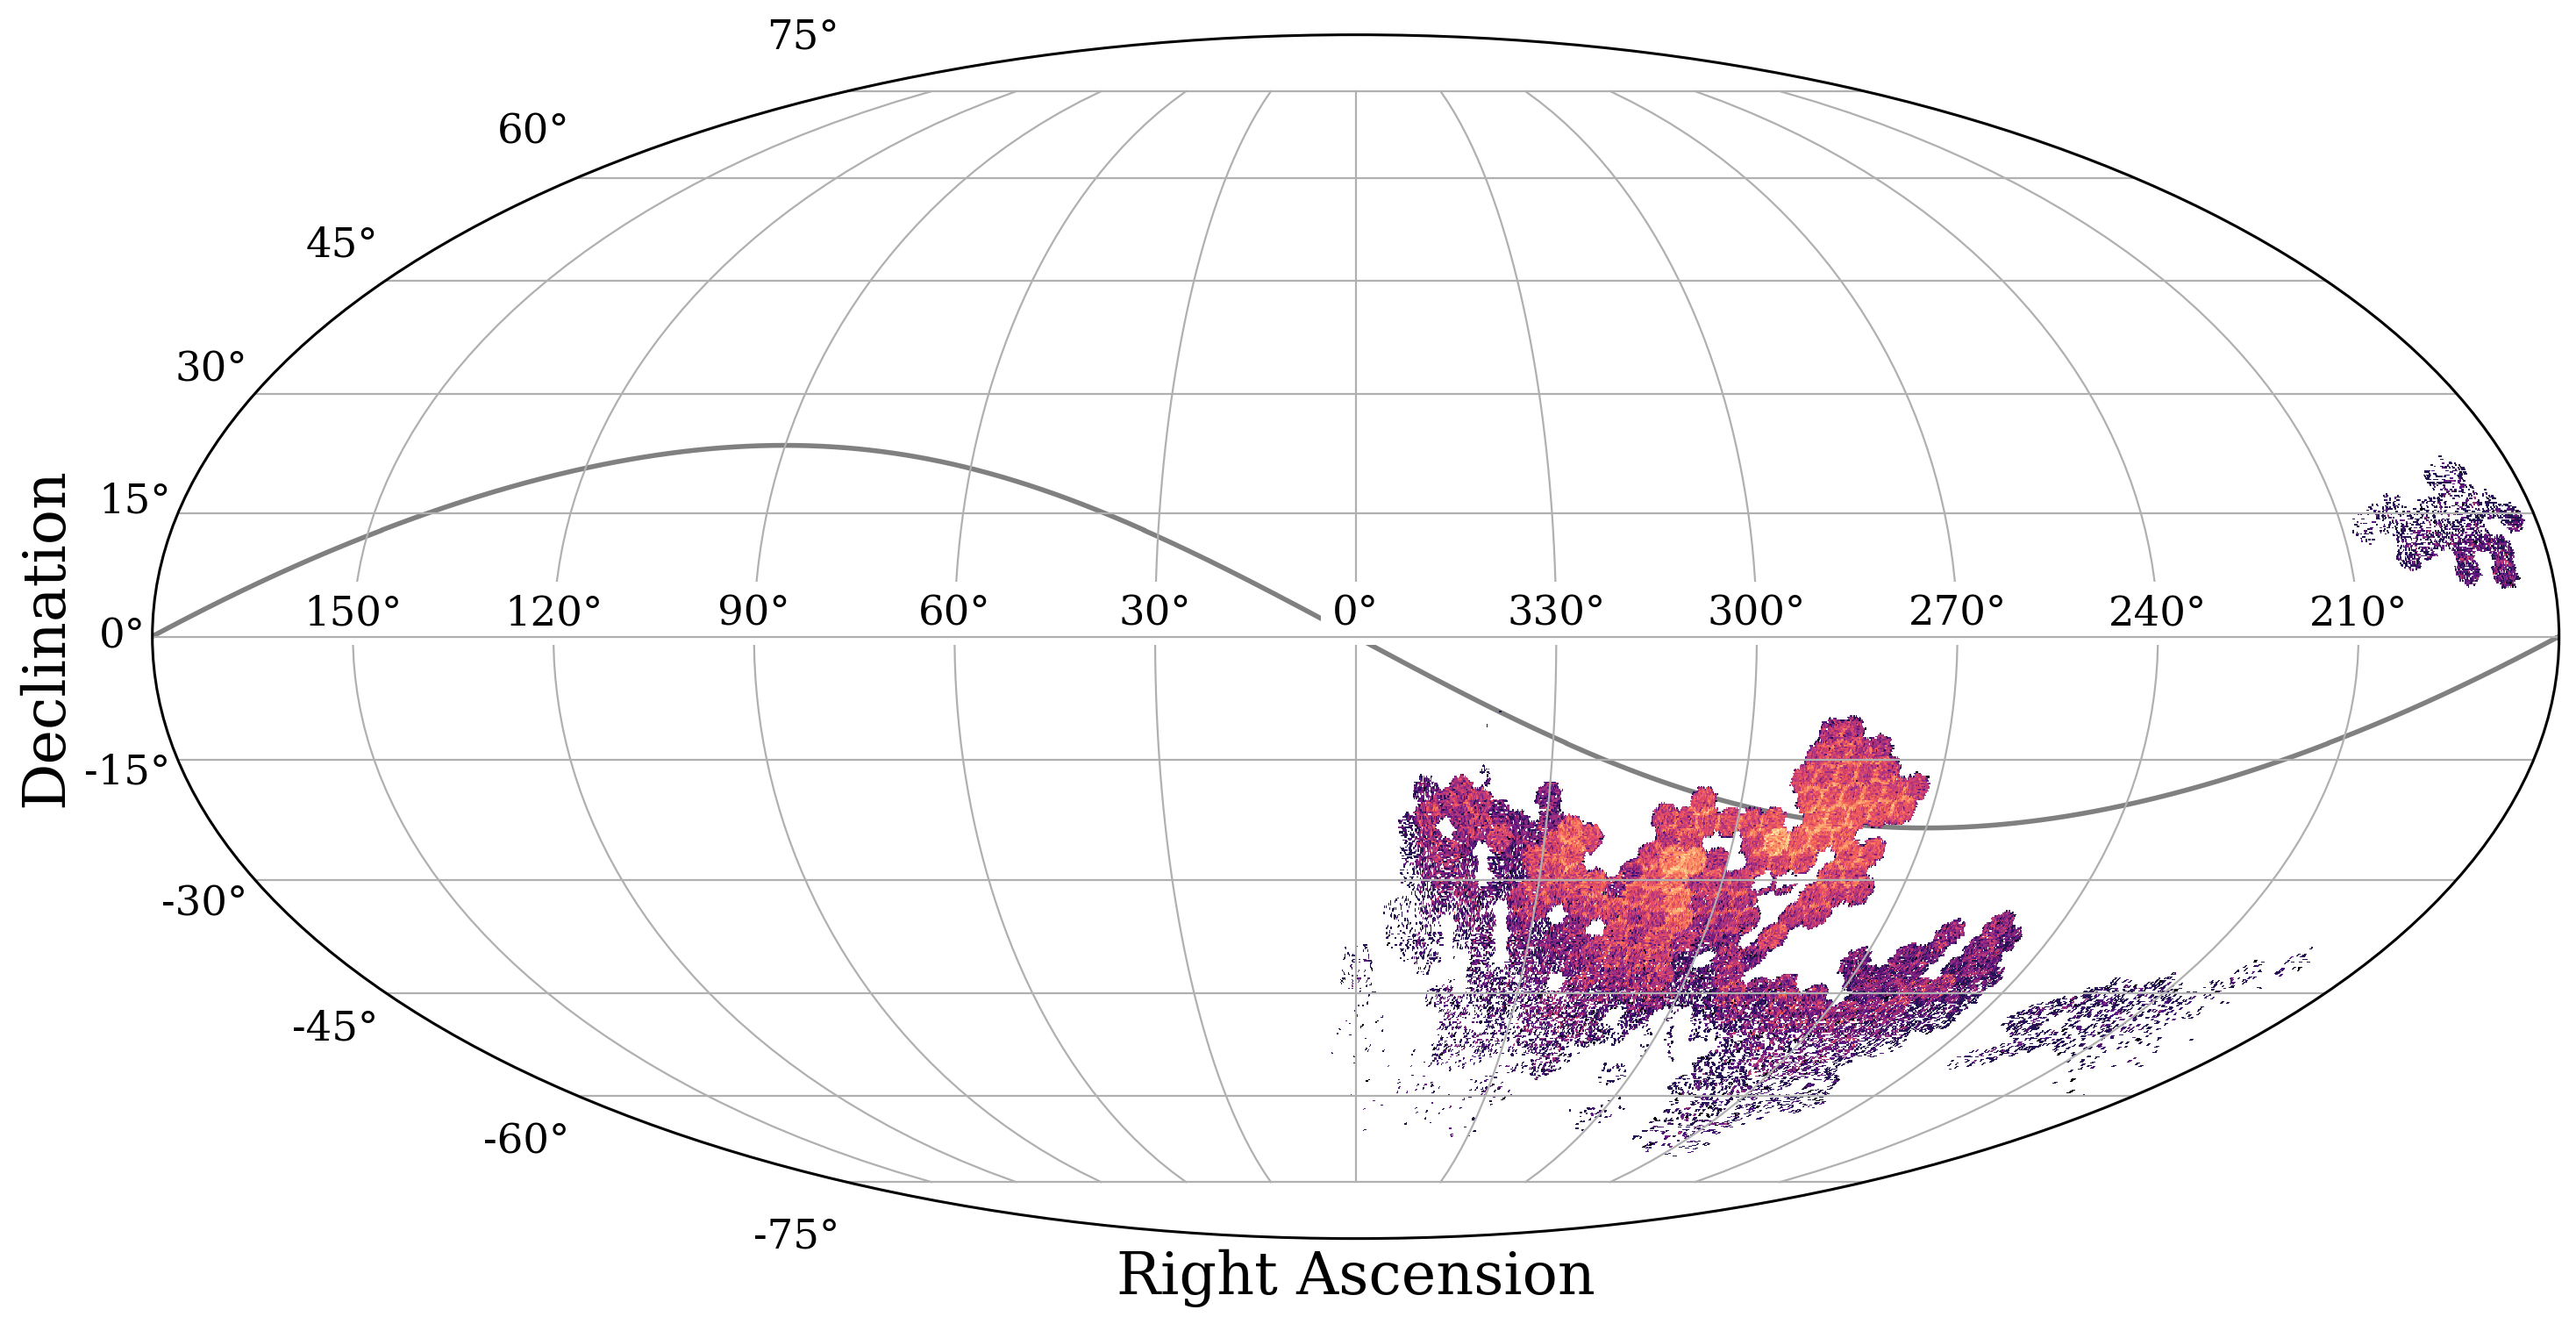

In [162]:
import healpy as hp
from matplotlib.colors import LogNorm

# I edited this from this example: https://github.com/zonca/paperplots/blob/master/python/scripts/PlanckFig_map.py

nside = int(2**8)

ra = np.array([])
dec = np.array([])
for obs in [neo_obs, mba_obs]:
    obs = obs[obs["night"] == night]
    print(len(obs))
    ra = np.concatenate((ra, obs["AstRA(deg)"].values))
    dec = np.concatenate((dec, obs["AstDec(deg)"].values))

ra, dec = np.radians(ra), np.radians(dec)
lat = np.pi / 2.0 - dec
hpids = hp.ang2pix(nside, lat, ra)

map_vals = np.zeros(hp.nside2npix(nside), dtype=float)
for idx in hpids:
    map_vals[idx] += 1

m = hp.ma(map_vals)

xsize = 2000
ysize = int(xsize/2)

theta = np.linspace(np.pi, 0, ysize)
phi   = np.linspace(-np.pi, np.pi, xsize)
longitude = np.radians(np.linspace(-180, 180, xsize))
latitude = np.radians(np.linspace(-90, 90, ysize))

# project the map to a rectangular matrix xsize x ysize
PHI, THETA = np.meshgrid(phi, theta)
grid_pix = hp.ang2pix(nside, THETA, PHI)

grid_map = m[grid_pix]

from matplotlib.projections.geo import GeoAxes

class ThetaFormatterShiftPi(GeoAxes.ThetaFormatter):
    """Shifts labelling by pi
    Shifts labelling from -180,180 to 0-360"""
    def __call__(self, x, pos=None):
        if x != 0:
            x *= -1
        if x < 0:
            x += 2*np.pi
        return GeoAxes.ThetaFormatter.__call__(self, x, pos)

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='mollweide')

# flip longitude to the astro convention
image = plt.pcolormesh(longitude[::-1], latitude, grid_map, rasterized=True, cmap=cmap, norm=LogNorm())

# graticule
ax.set_longitude_grid(30)
ax.xaxis.set_major_formatter(ThetaFormatterShiftPi(30))

ax.plot(ecliptic.ra.radian[::-1], ecliptic.dec.radian, color='grey', lw=2, zorder=-1)

# colorbar
# cb = fig.colorbar(image, orientation="horizontal", location="top", shrink=.6, pad=0.05)#, ticks=[vmin, vmax])
# cb.ax.xaxis.set_label_text("Number of Objects")
# cb.solids.set_edgecolor("face")

ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")

for label in ax.get_xticklabels():
    label.set_bbox(dict(facecolor='white', edgecolor='None'))

ax.tick_params(axis="x", labelsize=0.7*fs)
ax.tick_params(axis="y", labelsize=0.7*fs)
    
# remove white space around figure
spacing = 0.01
plt.subplots_adjust(bottom=spacing, top=1-spacing, left=spacing, right=1-spacing)

plt.grid(True)

plt.savefig("../paper/figures/observations_example.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Check tracklet lengths

In [6]:
def get_tracklet_length(df):
    init = SkyCoord(ra=df["AstRA(deg)"].iloc[0], dec=df["AstDec(deg)"].iloc[0], unit="deg")
    final = SkyCoord(ra=df["AstRA(deg)"].iloc[-1], dec=df["AstDec(deg)"].iloc[-1], unit="deg")
    
    return init.separation(final).to(u.arcsecond).value

In [16]:
mba_df = pd.read_hdf("mba/filtered_visit_000.h5")

In [20]:
%%time
mba_lengths = mba_df[mba_df["night"] == 0].groupby("ObjID").apply(get_tracklet_length)

CPU times: user 1min 4s, sys: 0 ns, total: 1min 4s
Wall time: 1min 4s


Text(0.5, 1.0, 'Tracklet lengths for night 0 of simulated data')

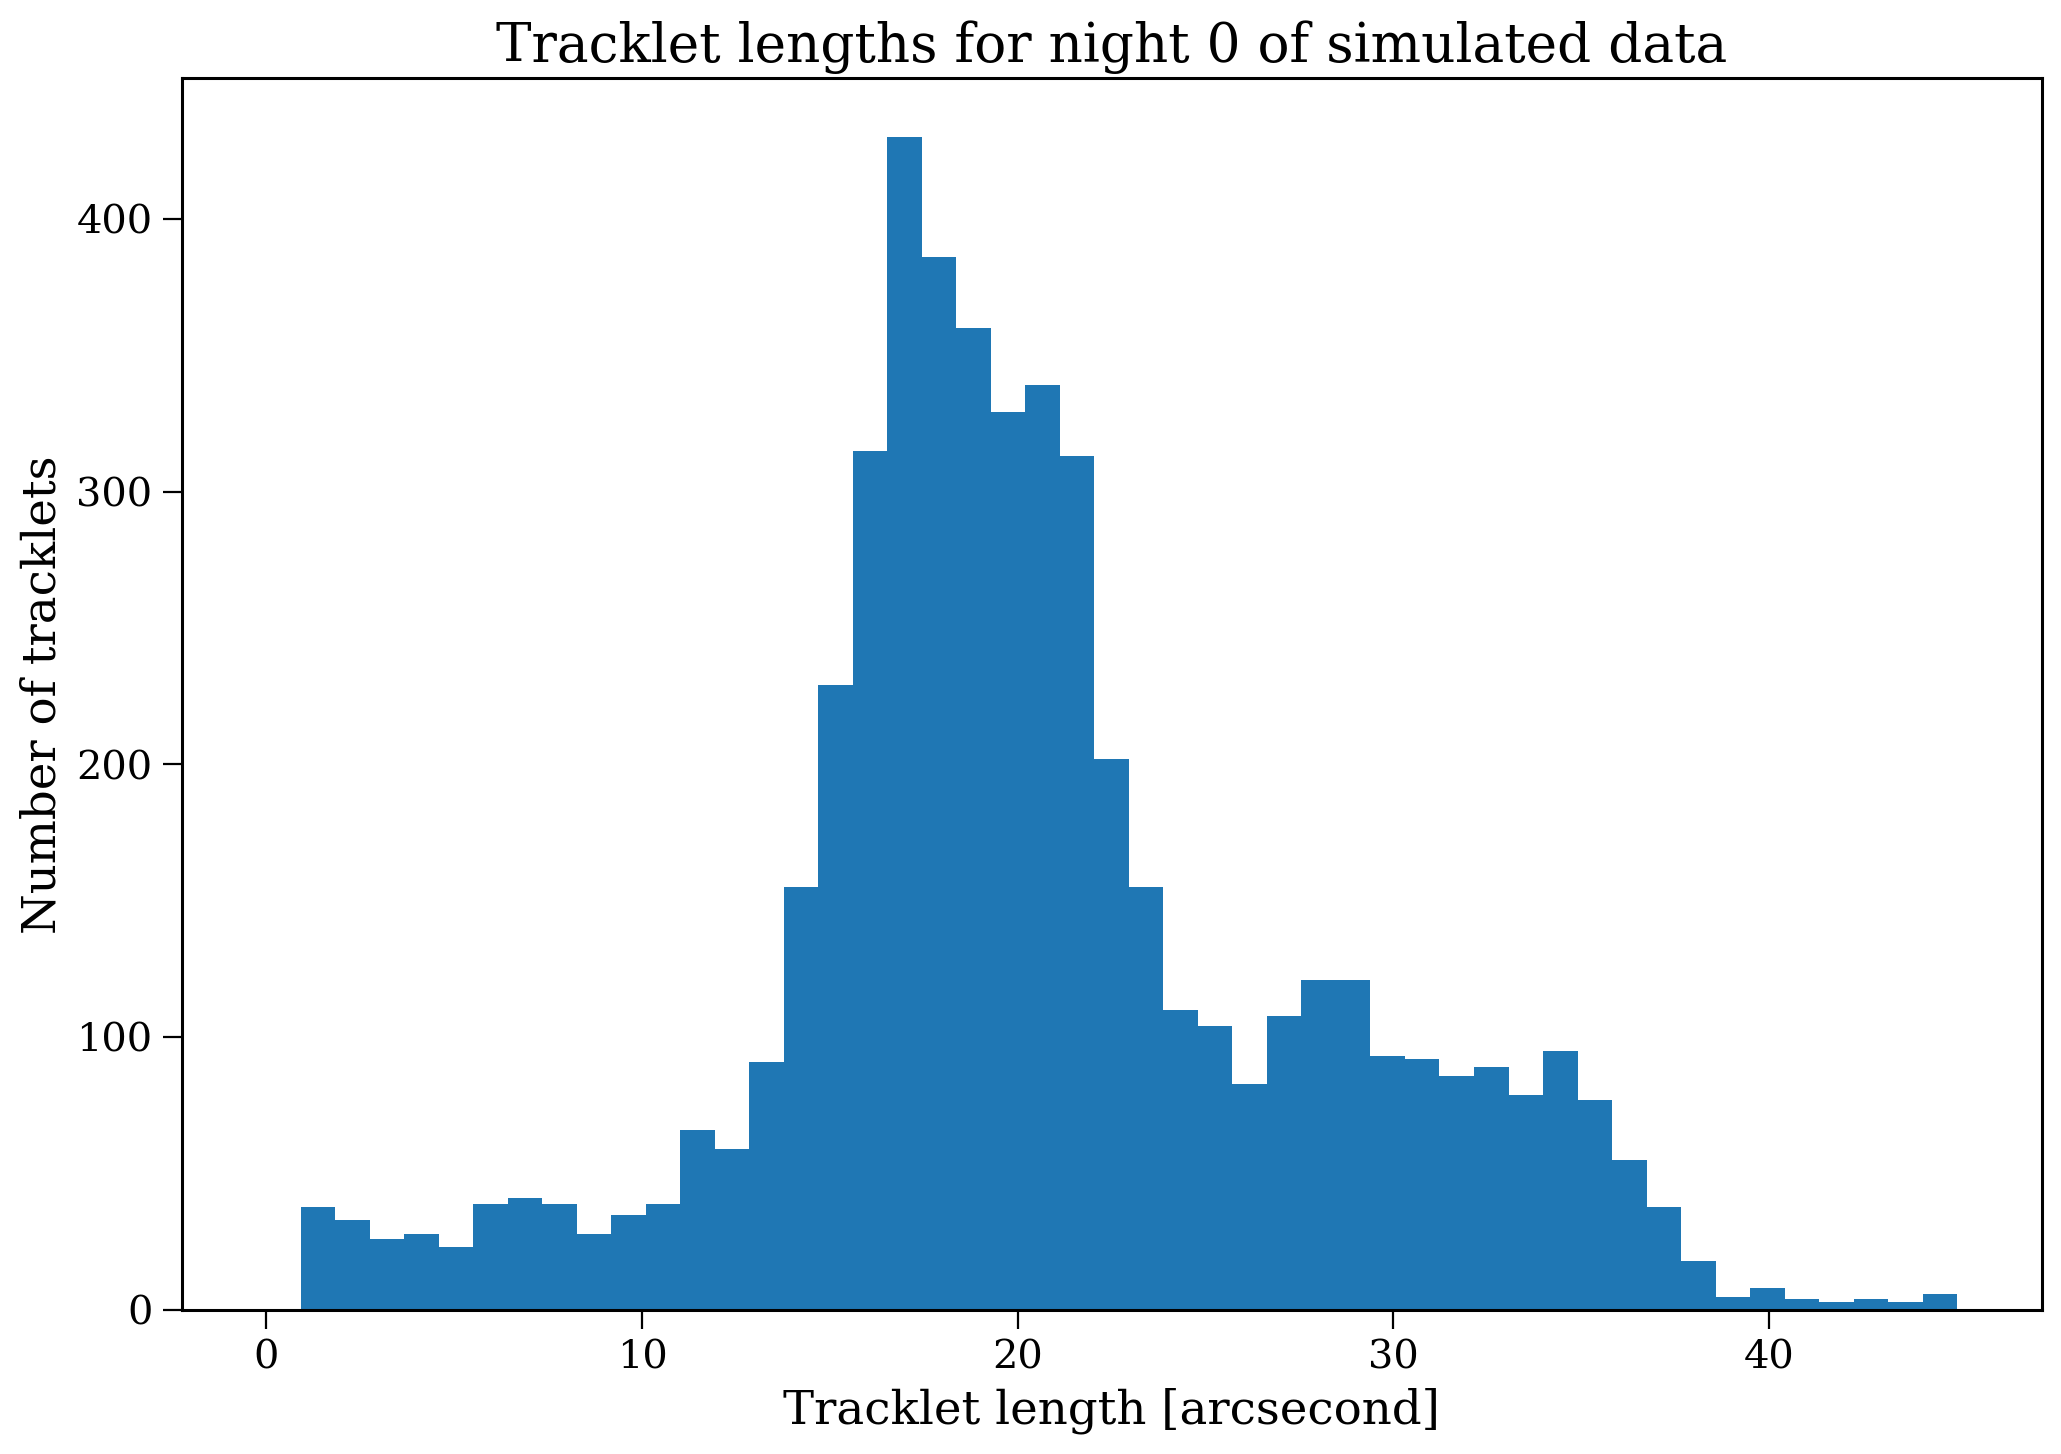

In [28]:
plt.hist(mba_lengths.values, bins="fd", range=(0, 45));
plt.xlabel("Tracklet length [arcsecond]", fontsize=0.7*fs)
plt.ylabel("Number of tracklets", fontsize=0.7*fs)
plt.title("Tracklet lengths for night 0 of simulated data", fontsize=0.8*fs)